High Level Data Description

This dataset is a synthetic loan portfolio focused on modeling the likelihood of loan default at the individual borrower level.​

Structure and target
The file is a flat CSV where each row represents a unique loan, identified by LoanID, with a binary target variable Default (0 = no default, 1 = default). The predictors mix numerical and categorical features describing borrower demographics, credit profile, and loan contract terms.​

Key numerical variables
Core continuous fields include borrower Age, Income, LoanAmount, CreditScore, MonthsEmployed, NumCreditLines, InterestRate, LoanTerm, and DTIRatio (debt-to-income ratio). These cover affordability, leverage, credit experience, and price of credit, which are typical drivers in credit risk modeling.​

Key categorical variables
Several categorical columns capture socioeconomic and relationship information: Education (e.g., High School, Bachelor's, Master's, PhD), EmploymentType (Full-time, Part-time, Self-employed, Unemployed), and MaritalStatus. Additional binary flags describe household and loan context: HasMortgage, HasDependents, LoanPurpose (Home, Auto, Business, Education, Other), and HasCoSigner.

Visualization of the Data

CREDIT RISK DATA VISUALIZATION & ANALYSIS
Objective: Maximize Trade Volume | Minimize Credit Losses

[1/7] Loading and Examining Data...
Successfully loaded data from: Loan_default.csv

Dataset Shape: 255,347 records x 18 features
Memory Usage: 126.81 MB

Numerical Features: 9
Categorical Features: 7
Target Variable: Default

[2/7] Creating Categorical Features Analysis...


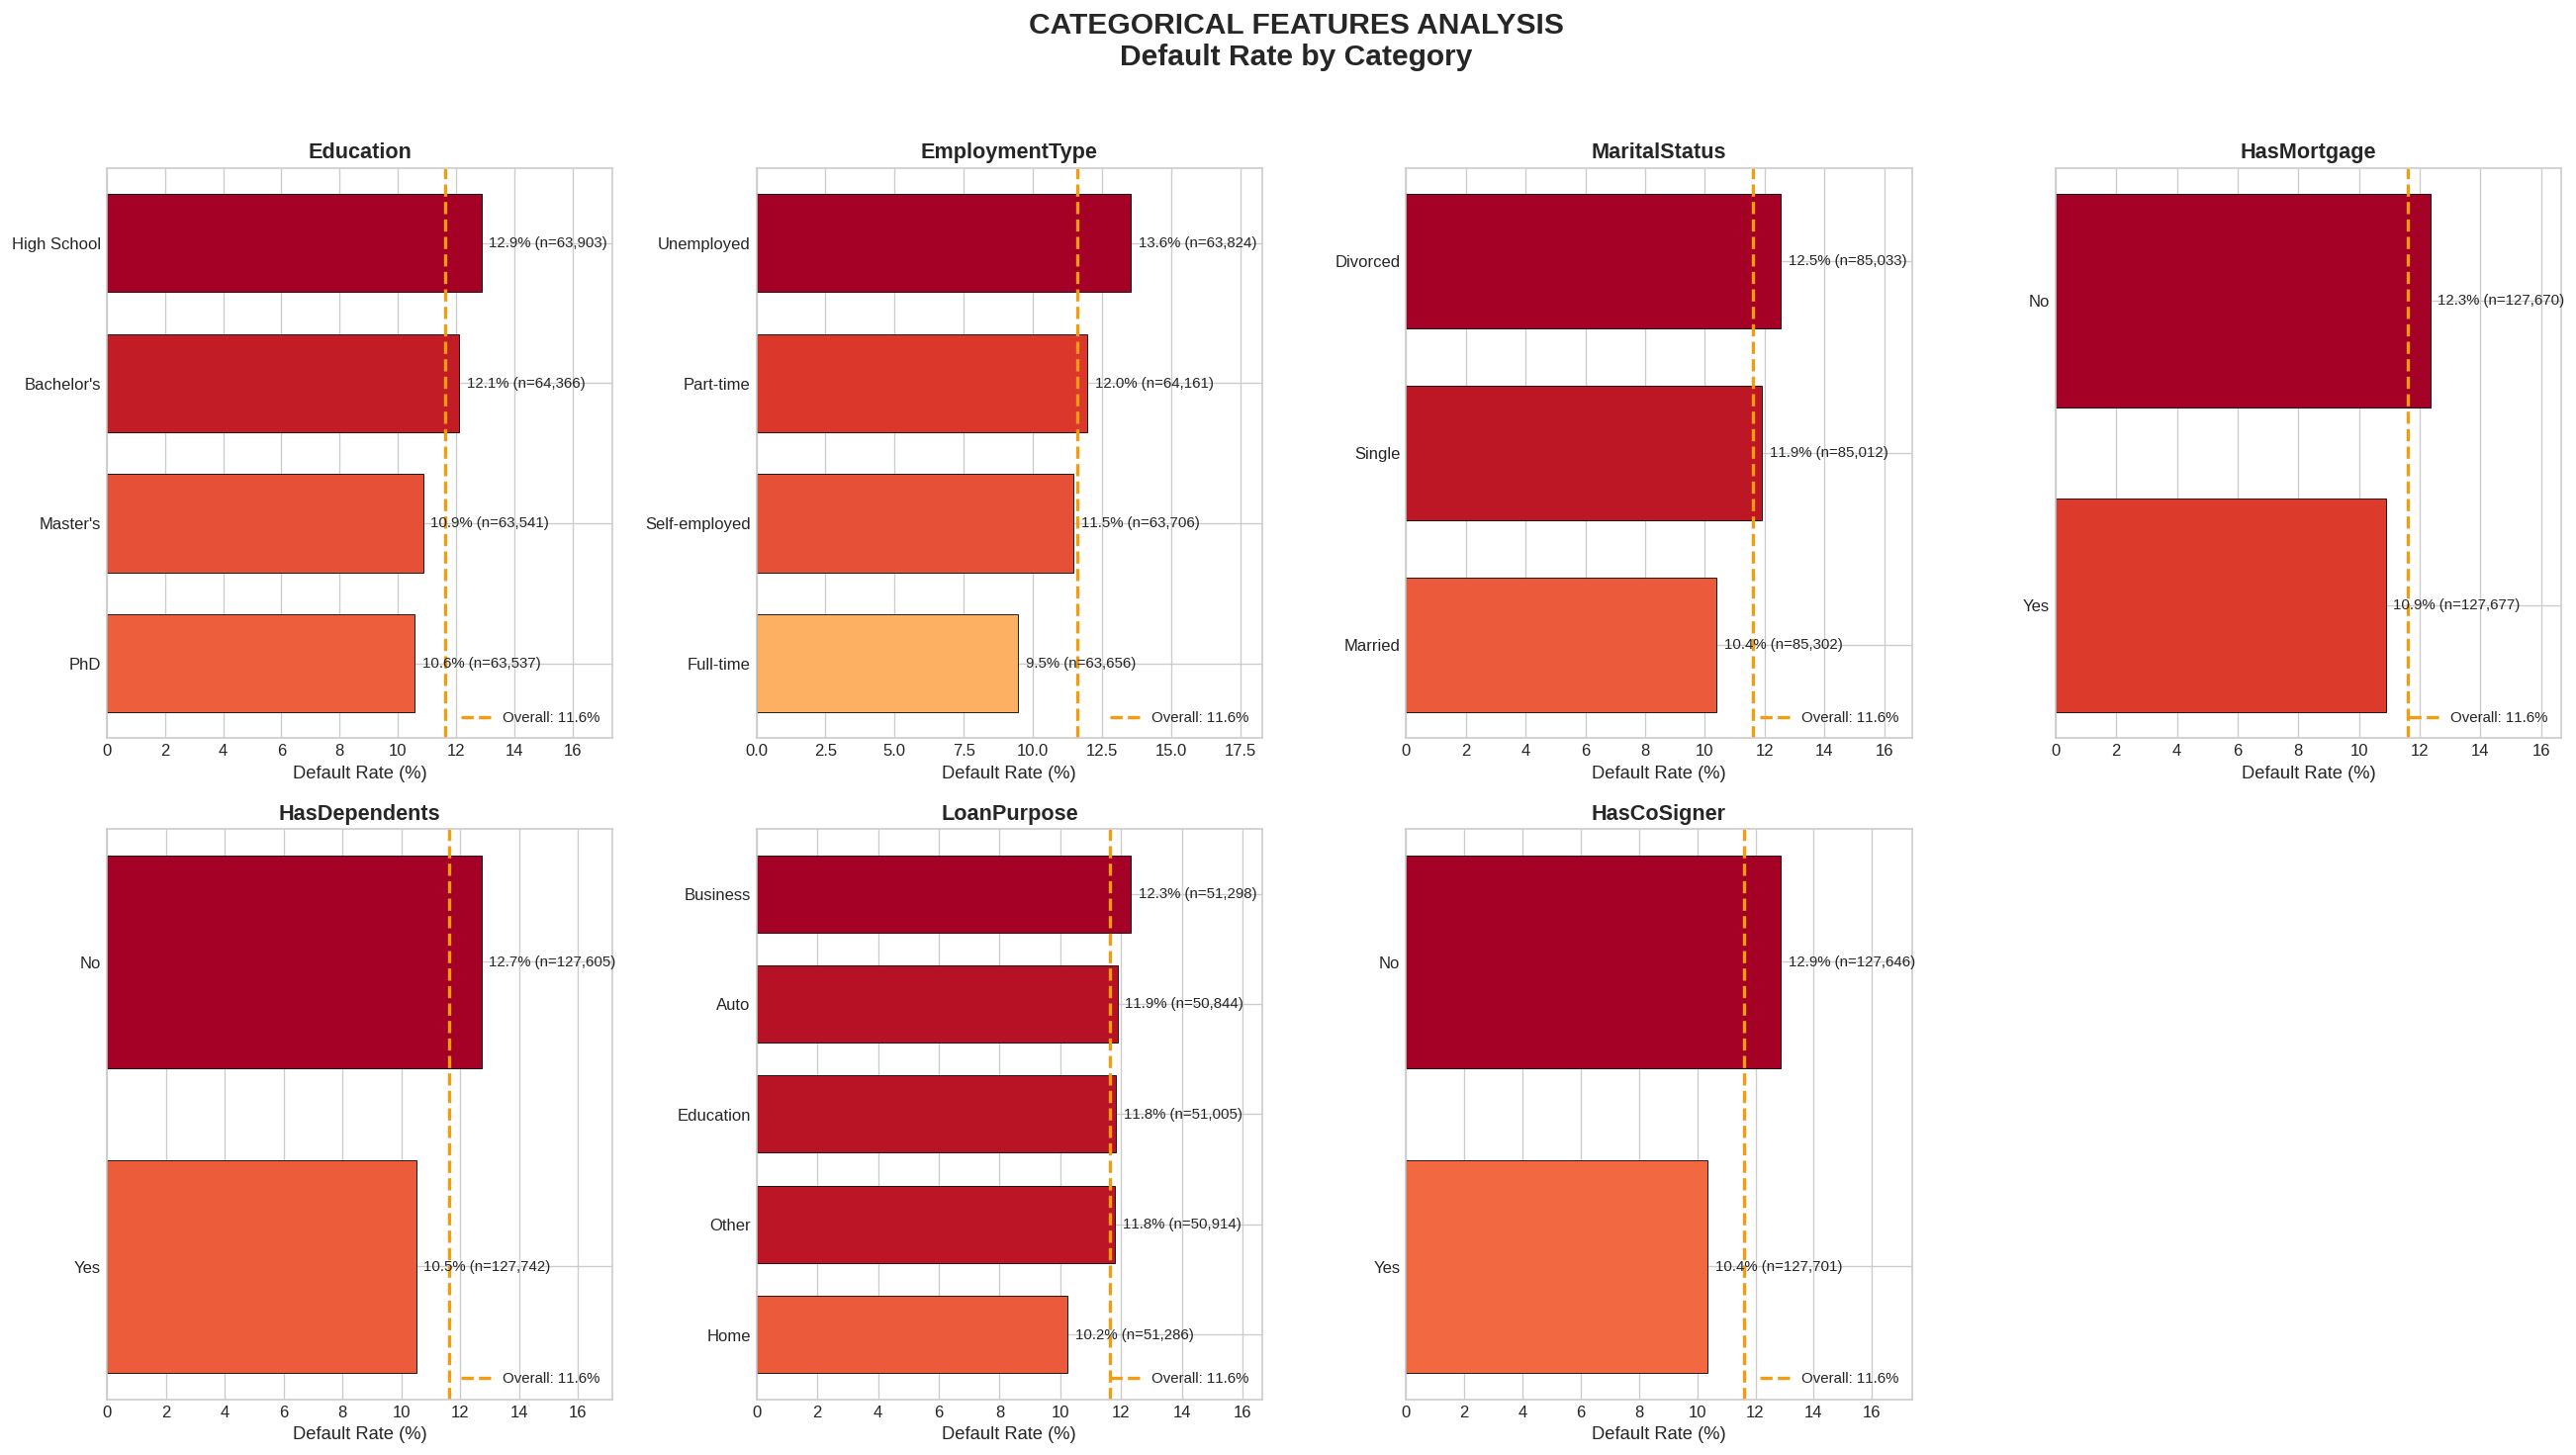


[3/7] Creating Correlation Analysis...


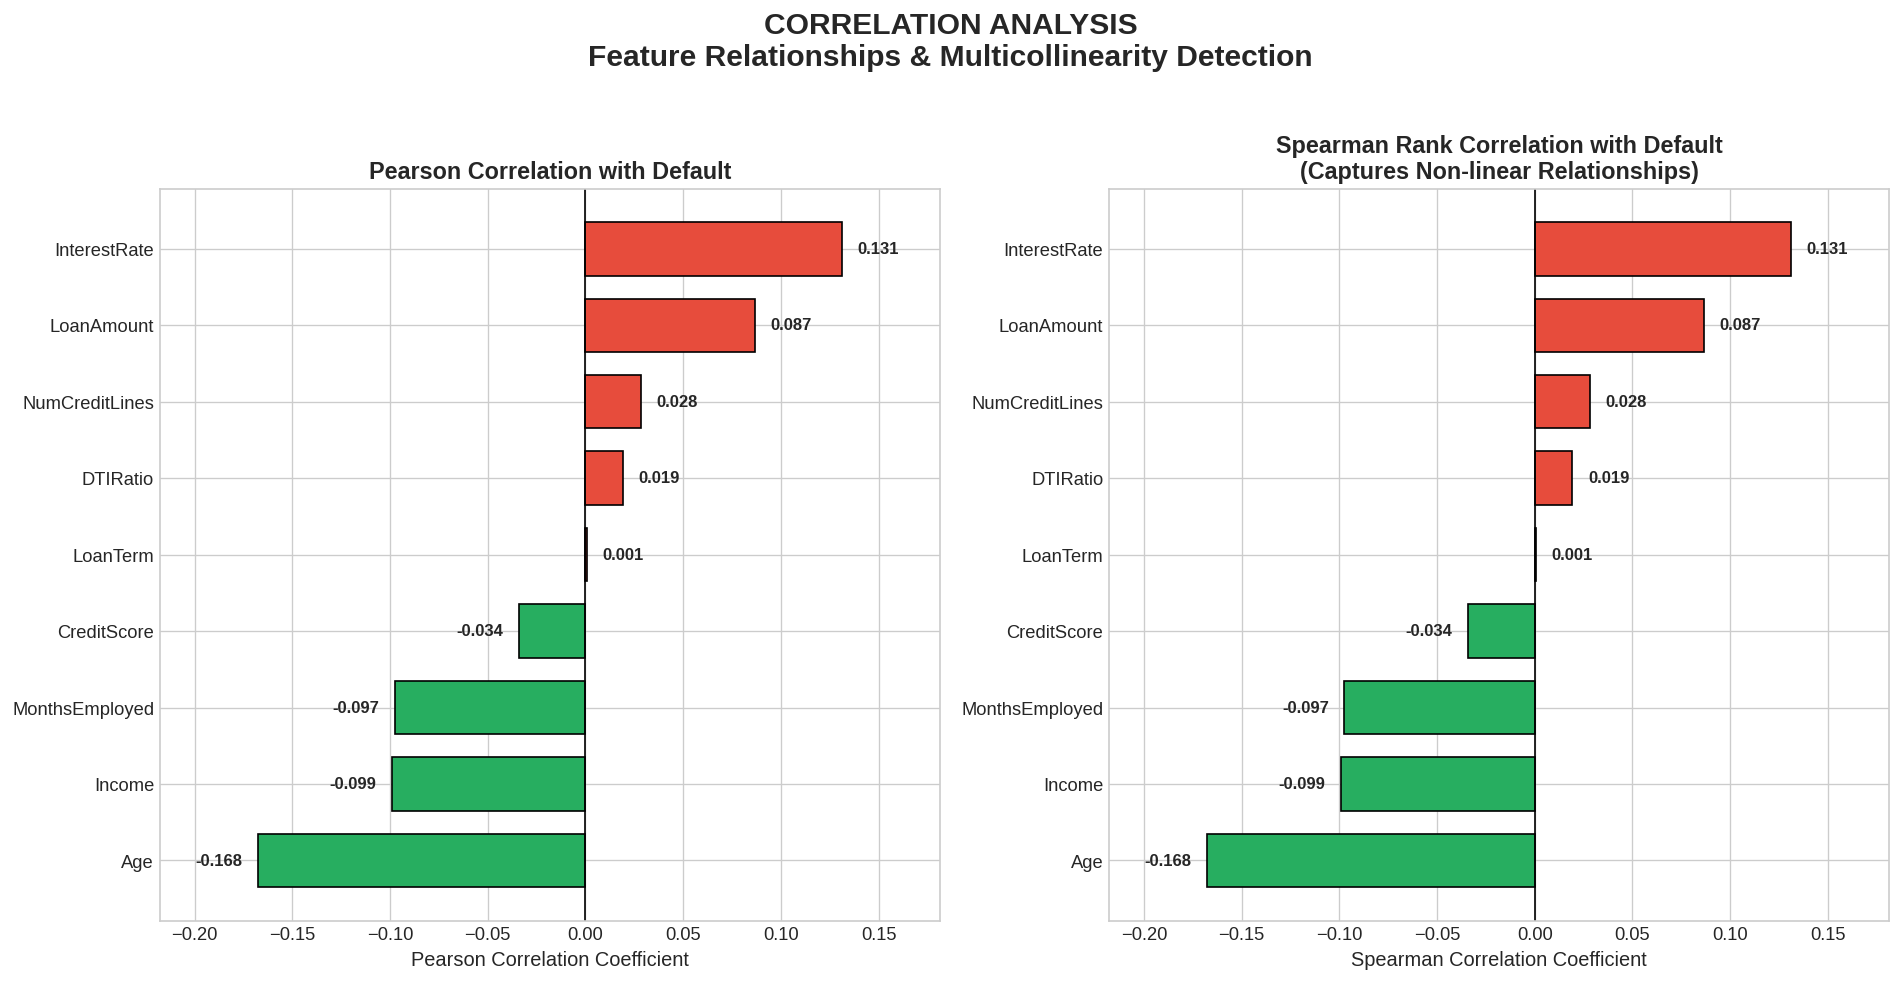


[4/7] Creating Risk Segmentation Analysis...


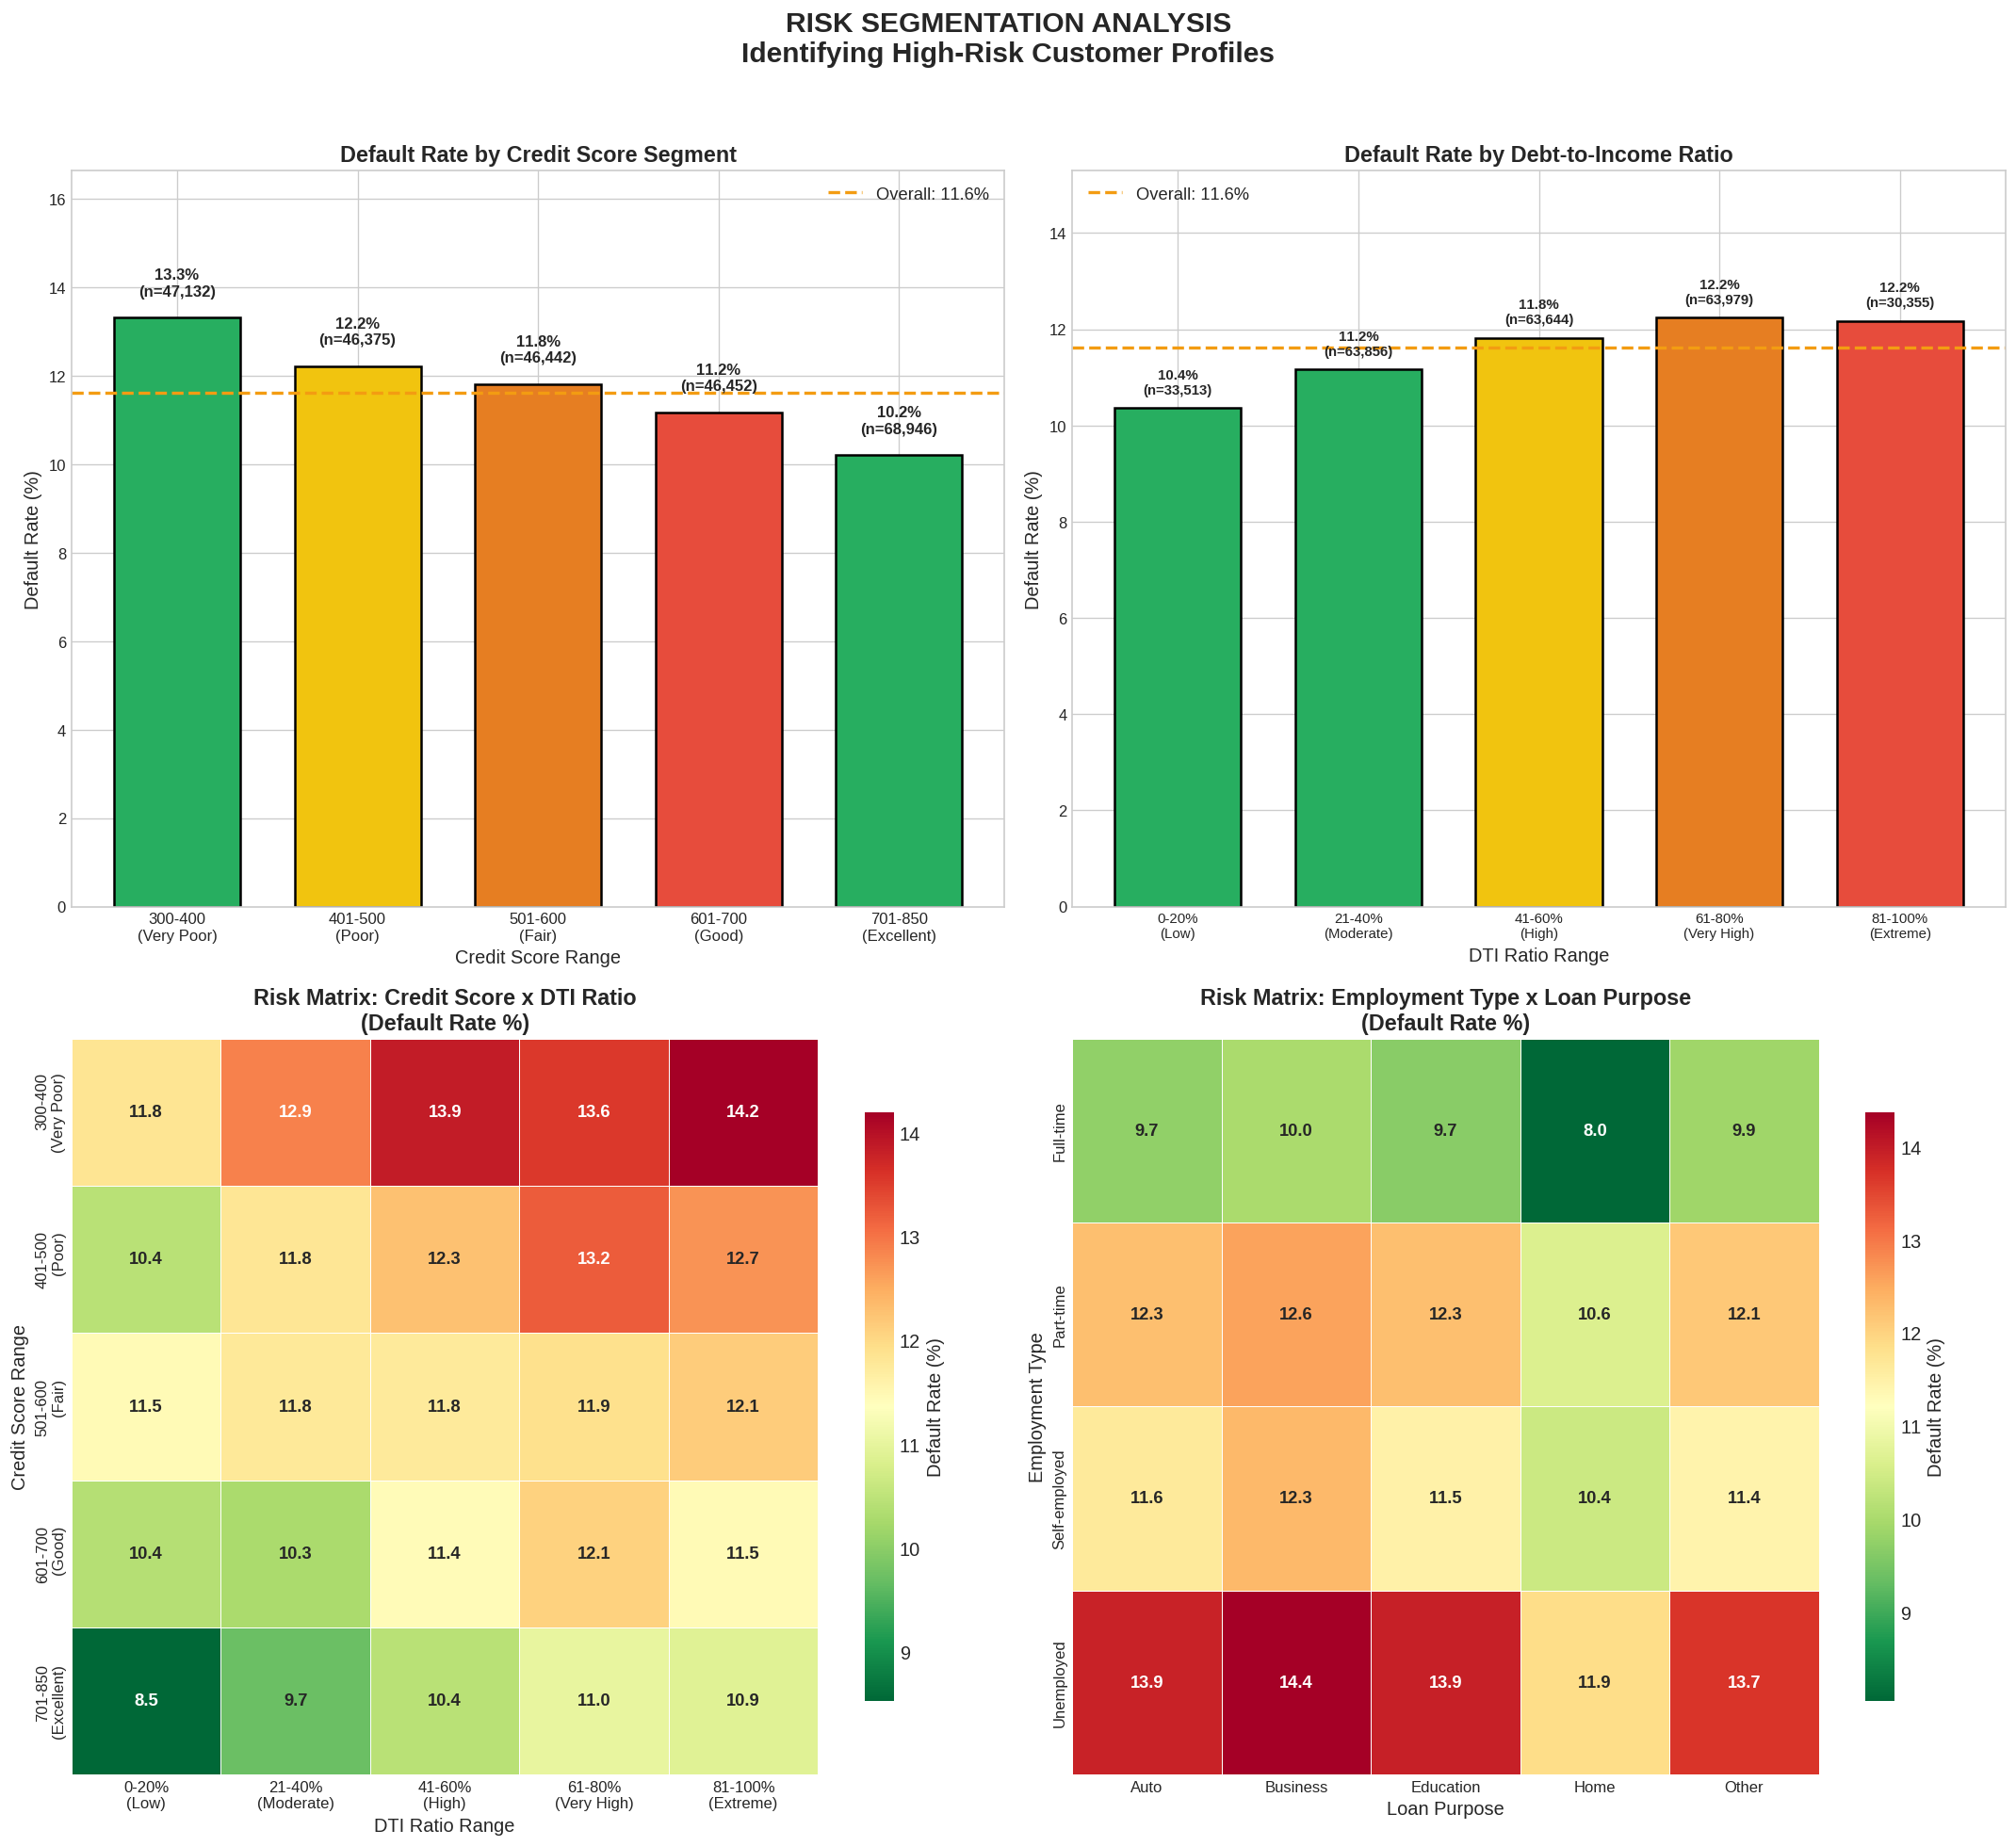


[5/7] Creating ECL Component Analysis...


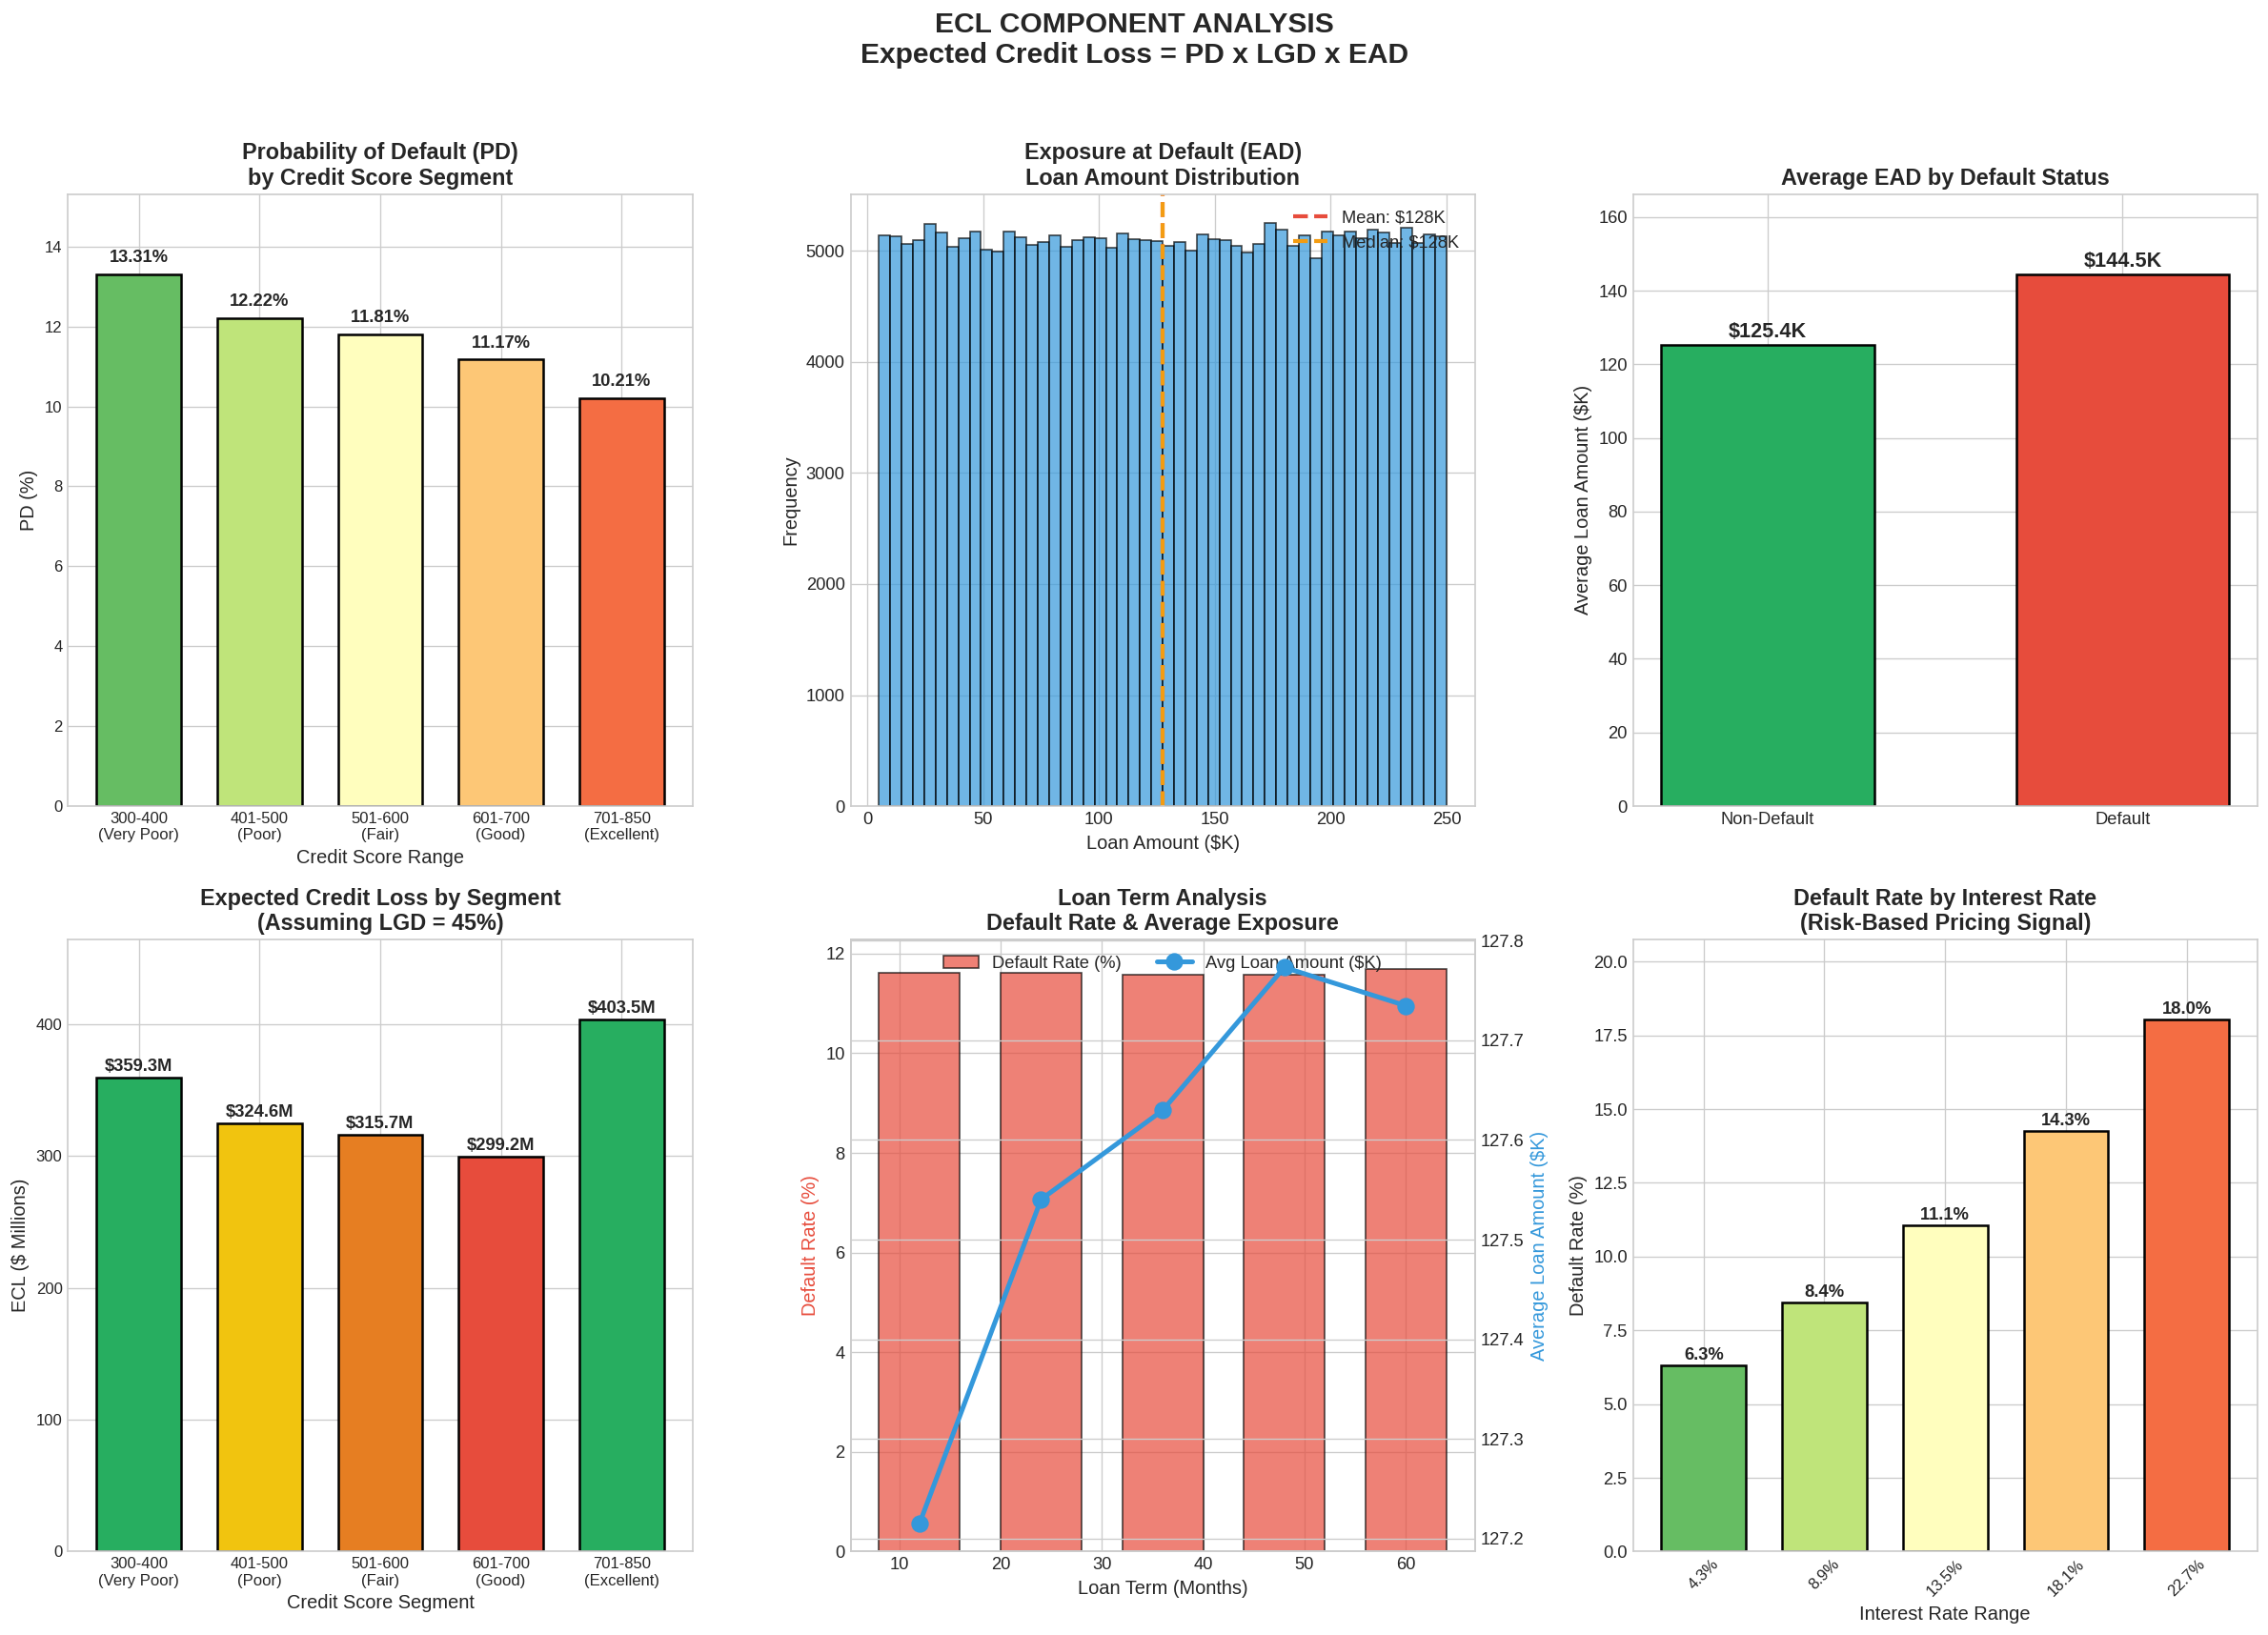


[6/7] Creating Business Metrics Analysis...


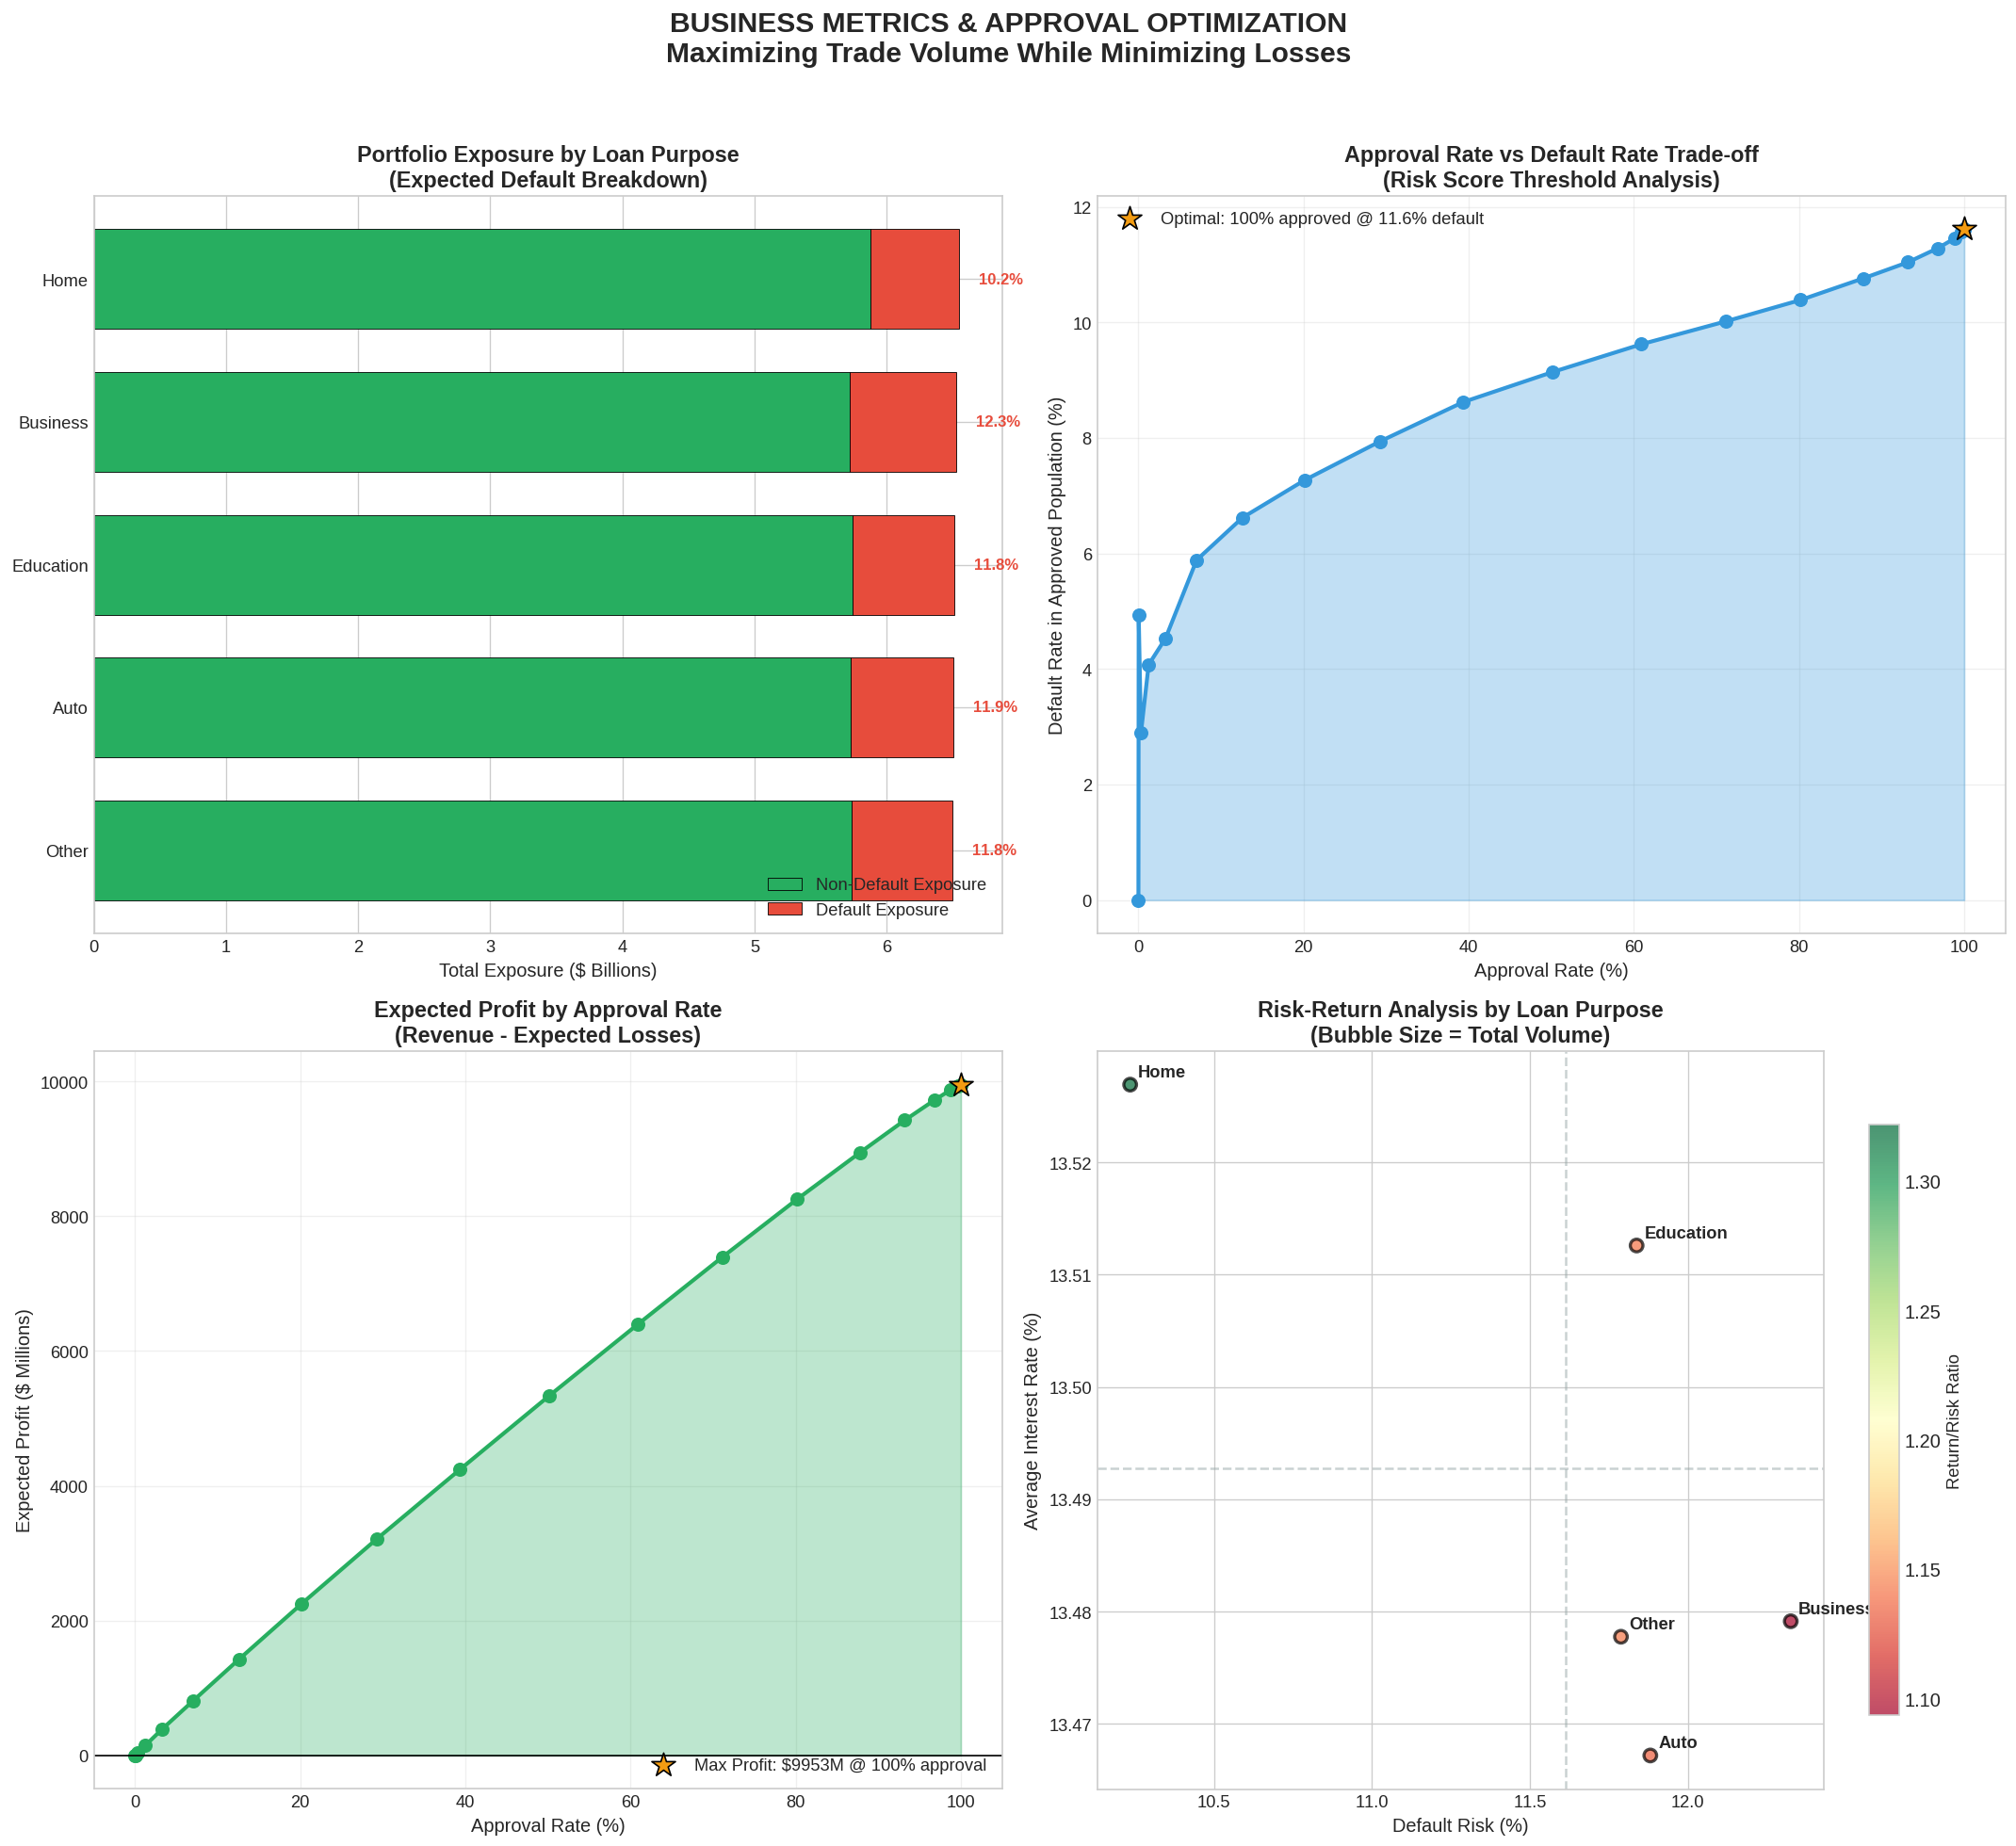


[7/7] Creating Advanced Bivariate Analysis...


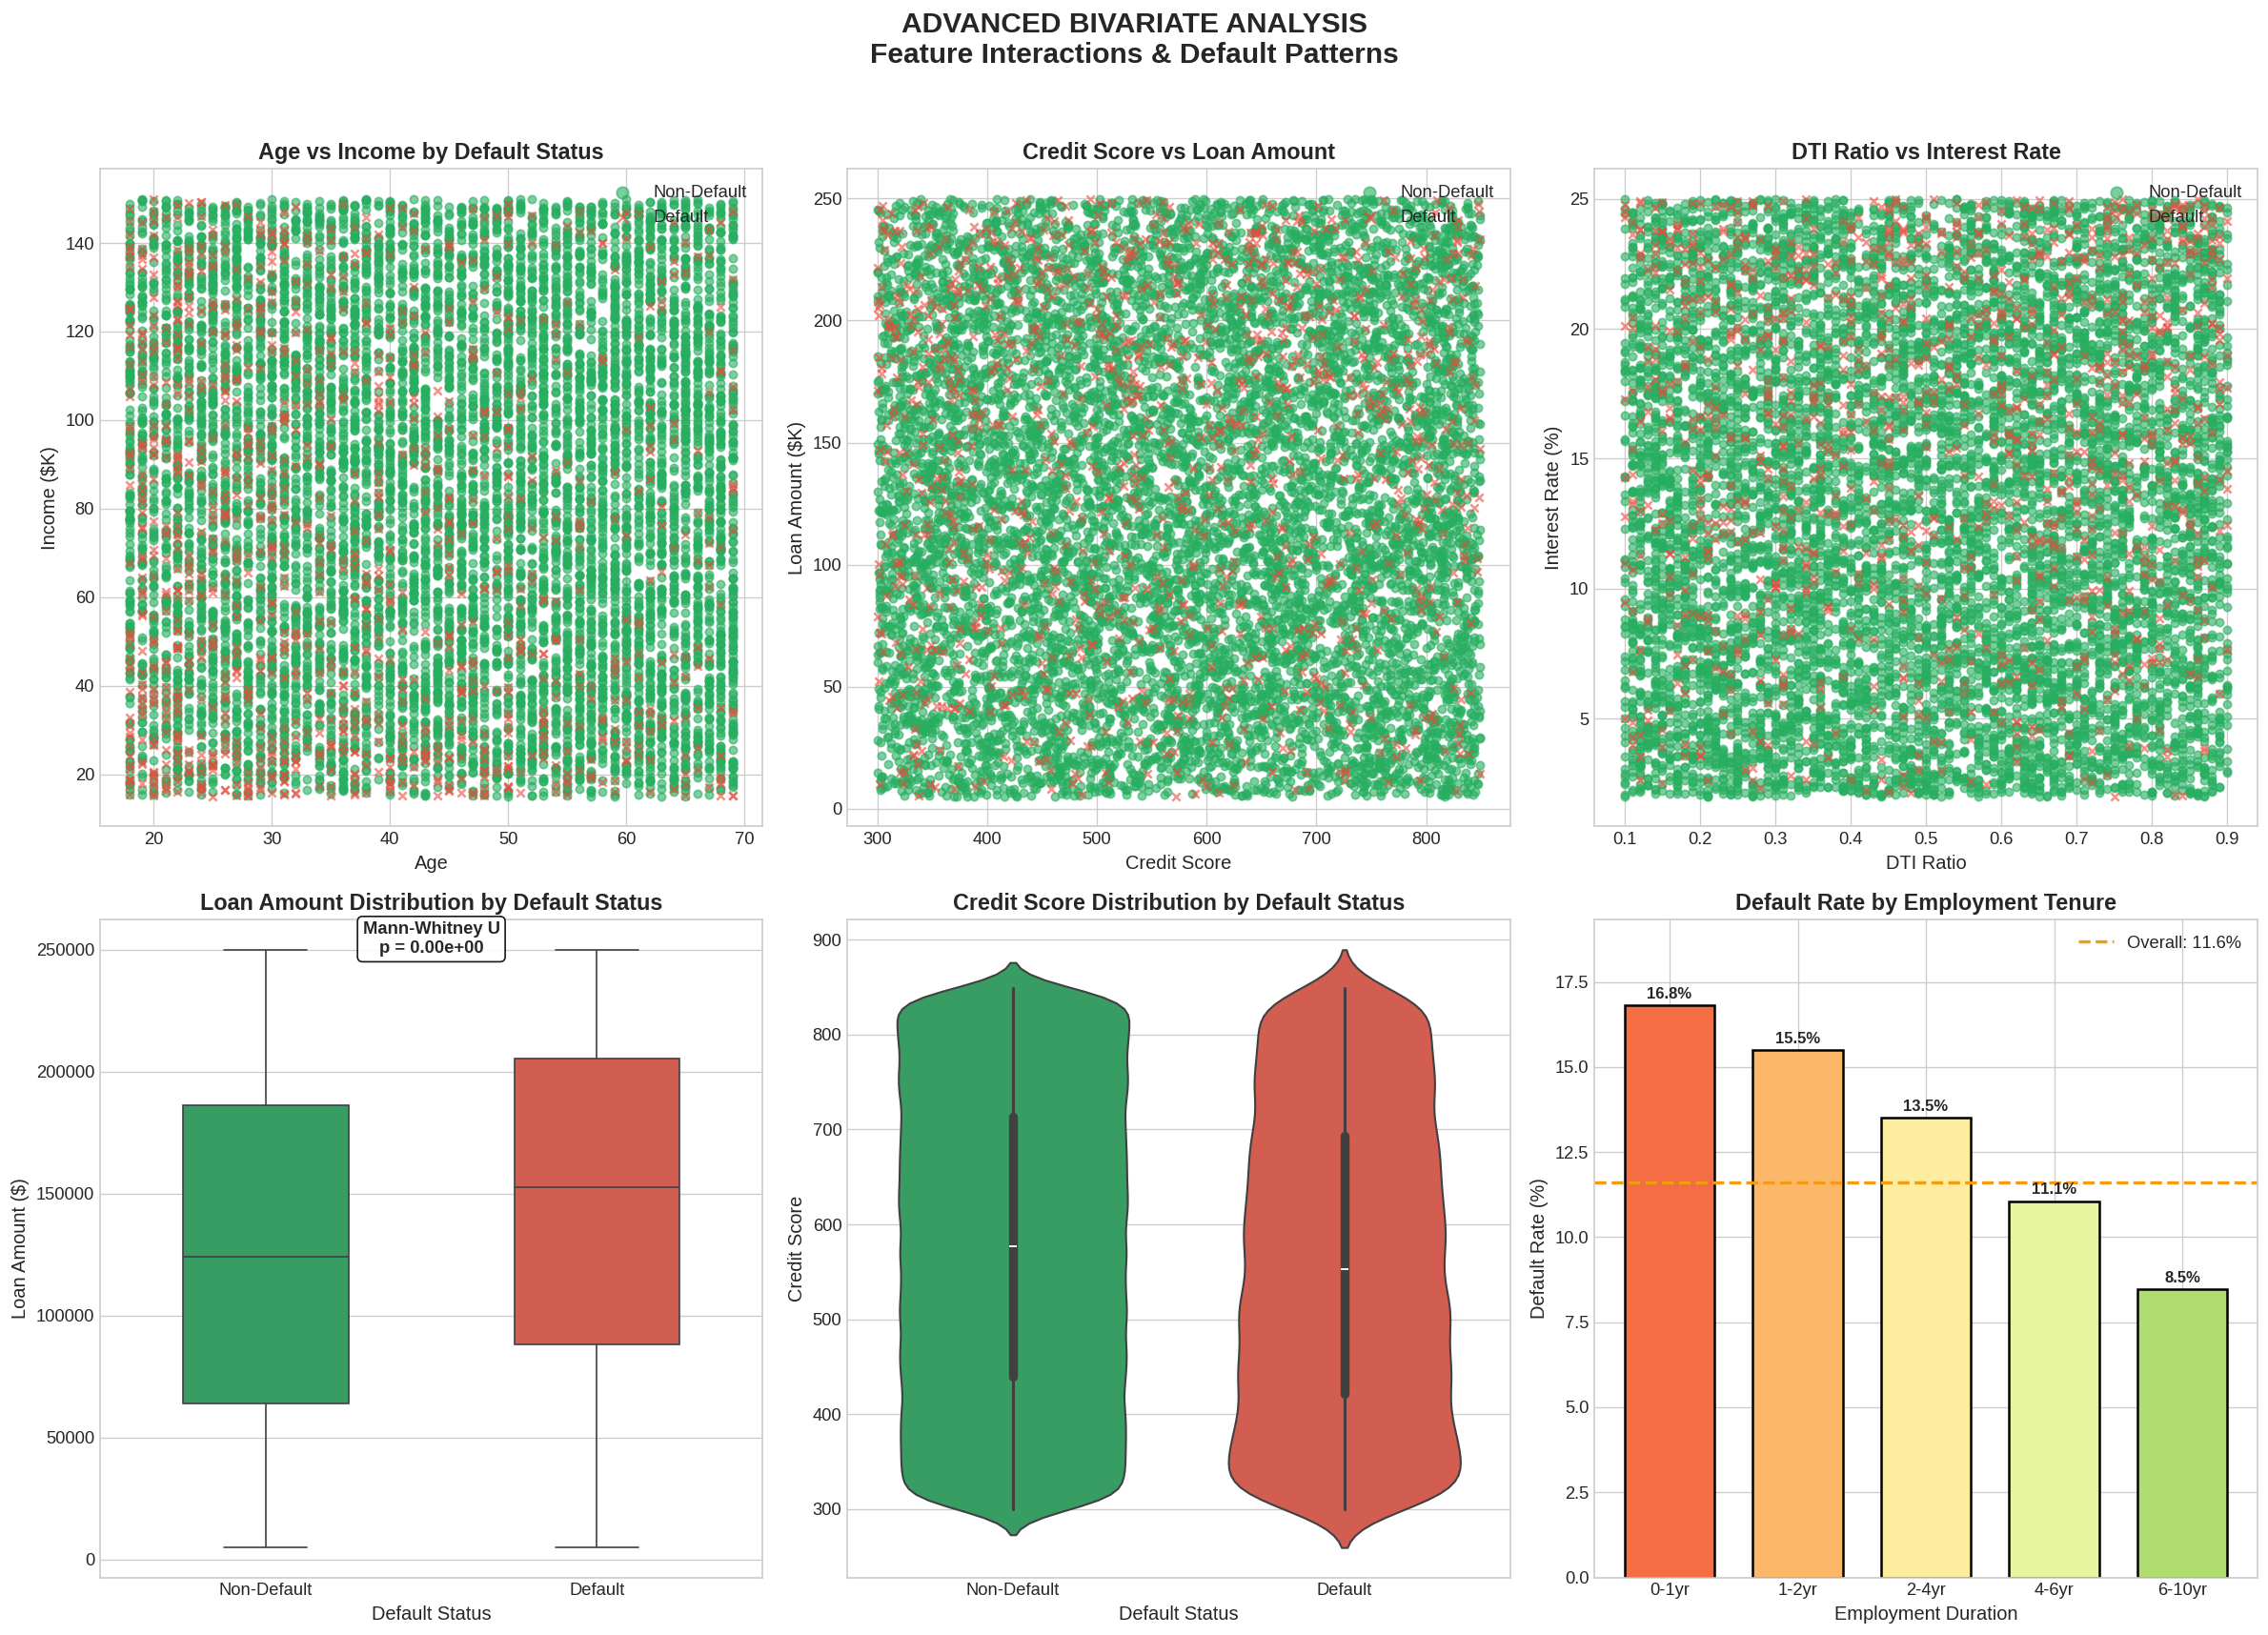


[Creating Feature Importance Analysis...]


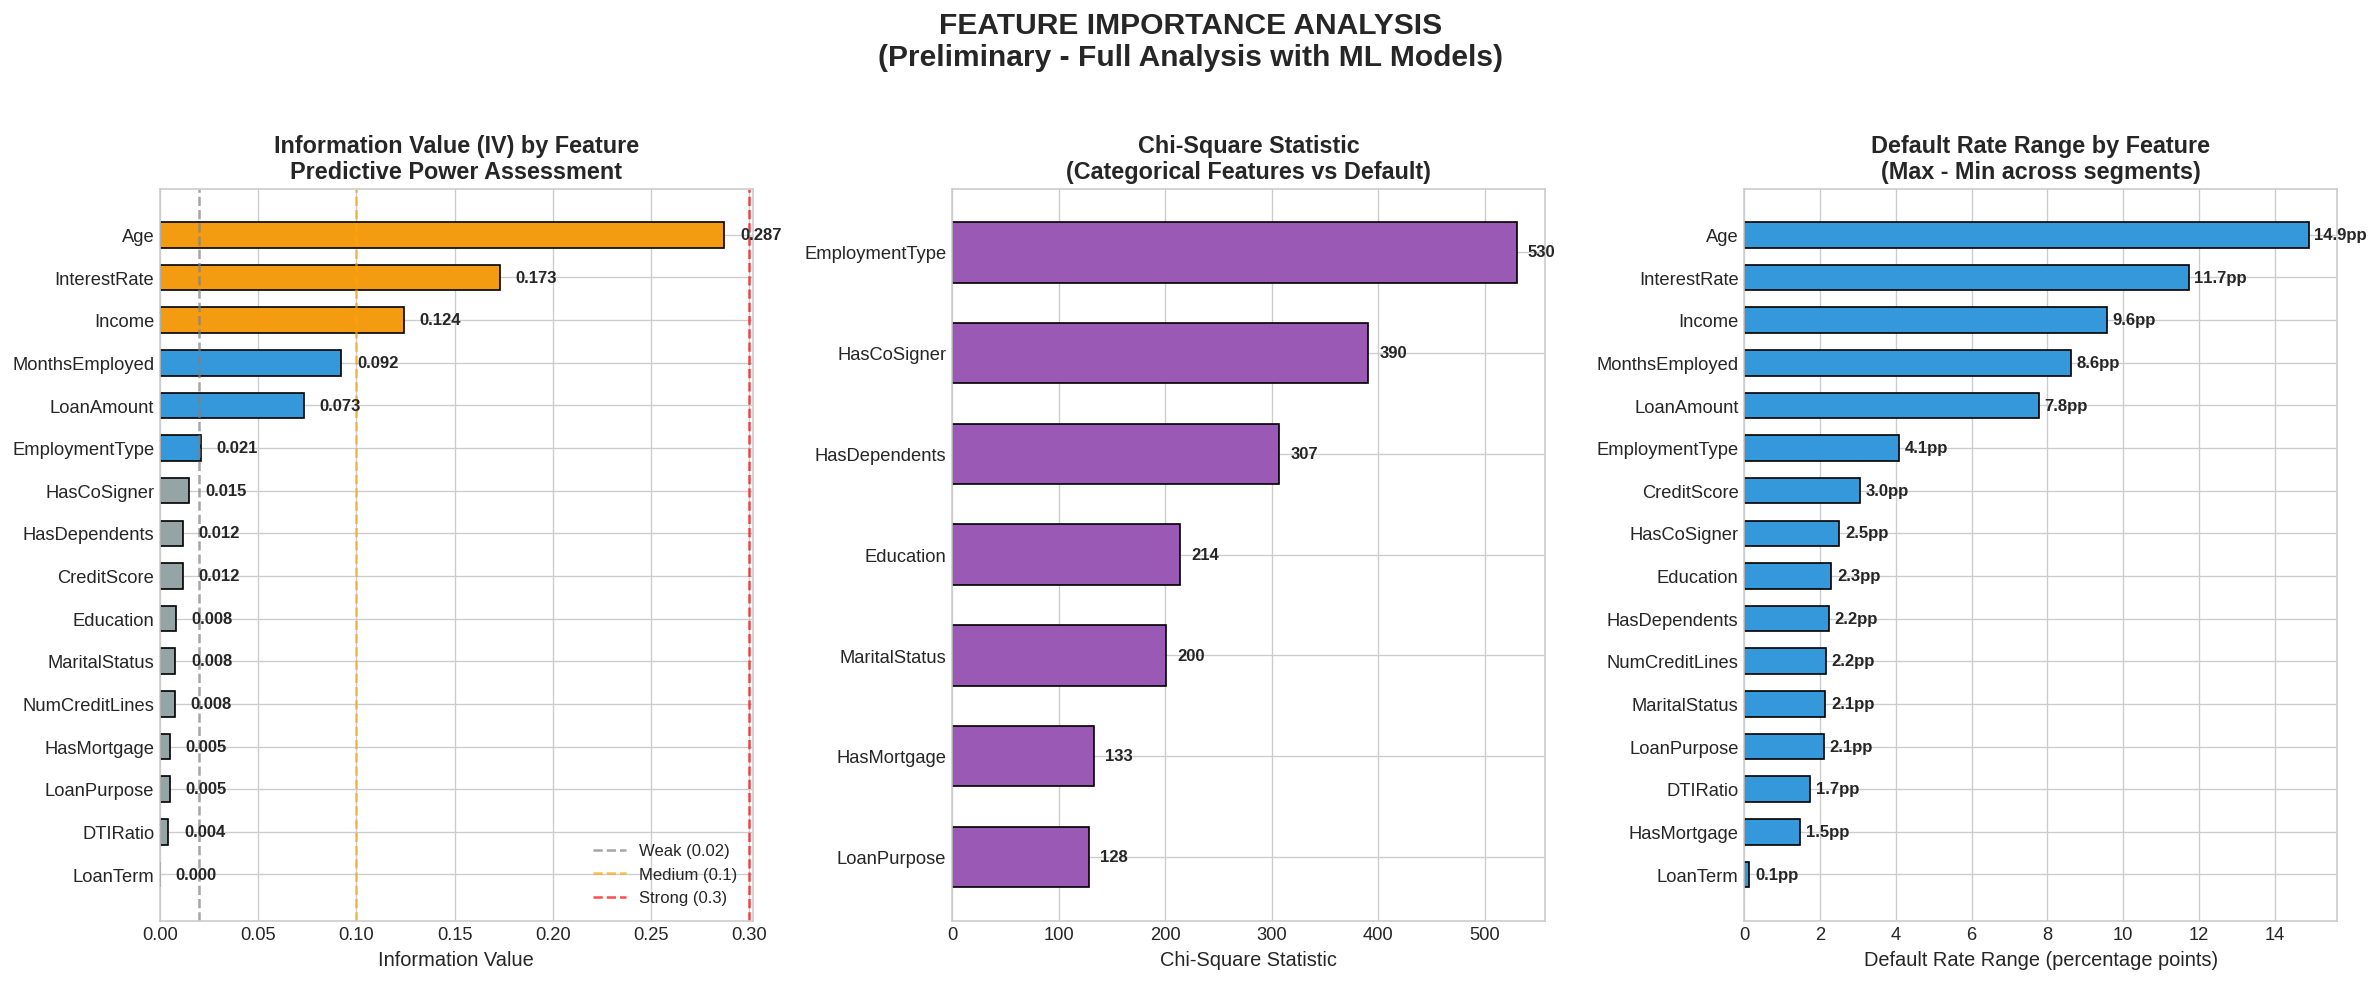


CREDIT RISK DATA ANALYSIS - SUMMARY REPORT

Dataset Size: 255,347 records
Default Rate: 11.61%
Imbalance Ratio: 7.6:1

--- Portfolio Statistics ---
Total Exposure: $32.58 Billion
Average Loan: $127,579
Average Interest Rate: 13.49%
Average Credit Score: 574
Average DTI Ratio: 50.0%

--- Top Predictive Features (by IV) ---
  1. Age: IV = 0.2875
  2. InterestRate: IV = 0.1731
  3. Income: IV = 0.1243
  4. MonthsEmployed: IV = 0.0924
  5. LoanAmount: IV = 0.0734


In [ ]:
FILE_PATH = 'Loan_default.csv'
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from scipy.stats import chi2_contingency, spearmanr, pearsonr
import warnings
warnings.filterwarnings('ignore')

# Set professional plotting style
plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 12
plt.rcParams['axes.titlesize'] = 14
plt.rcParams['axes.labelsize'] = 12
plt.rcParams['axes.titleweight'] = 'bold'
plt.rcParams['figure.dpi'] = 120
plt.rcParams['legend.fontsize'] = 10
plt.rcParams['legend.framealpha'] = 0.9

# Custom color palette for credit risk
COLORS = {
    'default': '#E74C3C',      # Red for default
    'non_default': '#27AE60',  # Green for non-default
    'primary': '#3498DB',      # Blue primary
    'secondary': '#9B59B6',    # Purple secondary
    'warning': '#F39C12',      # Orange warning
    'neutral': '#95A5A6',      # Gray neutral
}

# Risk-based color palette
RISK_PALETTE = ['#27AE60', '#F1C40F', '#E67E22', '#E74C3C']  # Low to High risk

print("=" * 80)
print("CREDIT RISK DATA VISUALIZATION & ANALYSIS")
print("Objective: Maximize Trade Volume | Minimize Credit Losses")
print("=" * 80)

# ==============================================================================
# SECTION 1: DATA LOADING & OVERVIEW
# ==============================================================================
print("\n[1/7] Loading and Examining Data...")

# Load data
try:
    df = pd.read_csv(FILE_PATH)
    print(f"Successfully loaded data from: {FILE_PATH}")
except FileNotFoundError:
    print(f"ERROR: File not found at '{FILE_PATH}'")
    print("\nINSTRUCTIONS:")
    print("   1. Update the FILE_PATH variable at the top of this script")
    print("   2. For Google Colab, upload your file first:")
    print("      from google.colab import files")
    print("      uploaded = files.upload()")
    print("   3. Then set FILE_PATH = 'Loan_default.csv'")
    raise

# Display basic info
print(f"\nDataset Shape: {df.shape[0]:,} records x {df.shape[1]} features")
print(f"Memory Usage: {df.memory_usage(deep=True).sum() / 1024**2:.2f} MB")

# Define feature types
numerical_features = ['Age', 'Income', 'LoanAmount', 'CreditScore', 'MonthsEmployed',
                      'NumCreditLines', 'InterestRate', 'LoanTerm', 'DTIRatio']
categorical_features = ['Education', 'EmploymentType', 'MaritalStatus',
                        'HasMortgage', 'HasDependents', 'LoanPurpose', 'HasCoSigner']
target = 'Default'

print(f"\nNumerical Features: {len(numerical_features)}")
print(f"Categorical Features: {len(categorical_features)}")
print(f"Target Variable: {target}")

# ==============================================================================
# FIGURE 1: CATEGORICAL FEATURES ANALYSIS
# ==============================================================================
print("\n[2/7] Creating Categorical Features Analysis...")

fig, axes = plt.subplots(2, 4, figsize=(22, 12))
axes = axes.flatten()
fig.suptitle('CATEGORICAL FEATURES ANALYSIS\nDefault Rate by Category',
             fontsize=18, fontweight='bold', y=1.02)

for idx, feature in enumerate(categorical_features):
    ax = axes[idx]

    # Calculate default rate by category
    cat_analysis = df.groupby(feature)[target].agg(['sum', 'count'])
    cat_analysis['default_rate'] = cat_analysis['sum'] / cat_analysis['count'] * 100
    cat_analysis = cat_analysis.sort_values('default_rate', ascending=True)

    # Create bar plot
    bars = ax.barh(cat_analysis.index, cat_analysis['default_rate'],
                   color=[plt.cm.RdYlGn_r(x/cat_analysis['default_rate'].max())
                          for x in cat_analysis['default_rate']],
                   edgecolor='black', linewidth=0.5, height=0.7)

    ax.set_title(f'{feature}', fontweight='bold', fontsize=13)
    ax.set_xlabel('Default Rate (%)', fontsize=11)
    ax.tick_params(axis='both', labelsize=10)

    # Add value labels with better positioning
    max_rate = cat_analysis['default_rate'].max()
    for bar, rate, count in zip(bars, cat_analysis['default_rate'], cat_analysis['count']):
        ax.text(bar.get_width() + max_rate*0.02, bar.get_y() + bar.get_height()/2,
                f'{rate:.1f}% (n={count:,})', va='center', fontsize=9)

    # Add overall average line
    overall_rate = df[target].mean() * 100
    ax.axvline(x=overall_rate, color=COLORS['warning'], linestyle='--', linewidth=2,
               label=f'Overall: {overall_rate:.1f}%')
    ax.legend(loc='lower right', fontsize=9, framealpha=0.9)

    # Adjust x-axis limit to accommodate labels
    ax.set_xlim(0, max_rate * 1.35)

# Hide the last empty subplot
axes[-1].axis('off')

plt.tight_layout()
plt.savefig('fig1_categorical_analysis.png', dpi=150, bbox_inches='tight',
            facecolor='white', edgecolor='none')
plt.show()

# ==============================================================================
# FIGURE 2: CORRELATION ANALYSIS (Without Pearson Matrix)
# ==============================================================================
print("\n[3/7] Creating Correlation Analysis...")

fig, axes = plt.subplots(1, 2, figsize=(16, 8))
fig.suptitle('CORRELATION ANALYSIS\nFeature Relationships & Multicollinearity Detection',
             fontsize=18, fontweight='bold', y=1.02)

# 2.1 Feature Correlation with Target (Pearson)
ax1 = axes[0]
target_corr = df[numerical_features].corrwith(df[target]).sort_values()
colors = [COLORS['non_default'] if x < 0 else COLORS['default'] for x in target_corr]
bars = ax1.barh(target_corr.index, target_corr.values, color=colors, edgecolor='black', height=0.7)
ax1.set_title('Pearson Correlation with Default', fontweight='bold', fontsize=14)
ax1.set_xlabel('Pearson Correlation Coefficient', fontsize=12)
ax1.axvline(x=0, color='black', linewidth=1)
ax1.tick_params(axis='both', labelsize=11)

# Add correlation values with better positioning
for bar, corr in zip(bars, target_corr.values):
    x_pos = corr + 0.008 if corr >= 0 else corr - 0.008
    ha = 'left' if corr >= 0 else 'right'
    ax1.text(x_pos, bar.get_y() + bar.get_height()/2, f'{corr:.3f}',
             va='center', ha=ha, fontsize=10, fontweight='bold')

# Adjust x-axis limits
ax1.set_xlim(min(target_corr.values) - 0.05, max(target_corr.values) + 0.05)

# 2.2 Spearman Rank Correlation with Target
ax2 = axes[1]
spearman_corr = {}
for feature in numerical_features:
    corr, _ = spearmanr(df[feature], df[target])
    spearman_corr[feature] = corr
spearman_series = pd.Series(spearman_corr).sort_values()
colors = [COLORS['non_default'] if x < 0 else COLORS['default'] for x in spearman_series]
bars = ax2.barh(spearman_series.index, spearman_series.values, color=colors, edgecolor='black', height=0.7)
ax2.set_title('Spearman Rank Correlation with Default\n(Captures Non-linear Relationships)', fontweight='bold', fontsize=14)
ax2.set_xlabel('Spearman Correlation Coefficient', fontsize=12)
ax2.axvline(x=0, color='black', linewidth=1)
ax2.tick_params(axis='both', labelsize=11)

for bar, corr in zip(bars, spearman_series.values):
    x_pos = corr + 0.008 if corr >= 0 else corr - 0.008
    ha = 'left' if corr >= 0 else 'right'
    ax2.text(x_pos, bar.get_y() + bar.get_height()/2, f'{corr:.3f}',
             va='center', ha=ha, fontsize=10, fontweight='bold')

# Adjust x-axis limits
ax2.set_xlim(min(spearman_series.values) - 0.05, max(spearman_series.values) + 0.05)

plt.tight_layout()
plt.savefig('fig2_correlation_analysis.png', dpi=150, bbox_inches='tight',
            facecolor='white', edgecolor='none')
plt.show()

# ==============================================================================
# FIGURE 3: RISK SEGMENTATION ANALYSIS
# ==============================================================================
print("\n[4/7] Creating Risk Segmentation Analysis...")

fig, axes = plt.subplots(2, 2, figsize=(18, 16))
fig.suptitle('RISK SEGMENTATION ANALYSIS\nIdentifying High-Risk Customer Profiles',
             fontsize=18, fontweight='bold', y=1.02)

# Create bins for analysis
df['CreditScore_Bin'] = pd.cut(df['CreditScore'], bins=[0, 400, 500, 600, 700, 850],
                                labels=['300-400\n(Very Poor)', '401-500\n(Poor)',
                                        '501-600\n(Fair)', '601-700\n(Good)', '701-850\n(Excellent)'])
df['DTI_Bin'] = pd.cut(df['DTIRatio'], bins=[0, 0.2, 0.4, 0.6, 0.8, 1.0],
                        labels=['0-20%\n(Low)', '21-40%\n(Moderate)', '41-60%\n(High)',
                                '61-80%\n(Very High)', '81-100%\n(Extreme)'])

# 3.1 Default Rate by Credit Score Bins
ax1 = axes[0, 0]
credit_analysis = df.groupby('CreditScore_Bin')[target].agg(['mean', 'count'])
credit_analysis['default_rate'] = credit_analysis['mean'] * 100

bars = ax1.bar(credit_analysis.index, credit_analysis['default_rate'],
               color=RISK_PALETTE + [COLORS['non_default']], edgecolor='black', linewidth=1.5, width=0.7)
ax1.set_title('Default Rate by Credit Score Segment', fontweight='bold', fontsize=14)
ax1.set_xlabel('Credit Score Range', fontsize=12)
ax1.set_ylabel('Default Rate (%)', fontsize=12)
ax1.axhline(y=df[target].mean()*100, color=COLORS['warning'], linestyle='--',
            linewidth=2, label=f'Overall: {df[target].mean()*100:.1f}%')
ax1.tick_params(axis='both', labelsize=10)

for bar, rate, count in zip(bars, credit_analysis['default_rate'], credit_analysis['count']):
    ax1.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.5,
             f'{rate:.1f}%\n(n={count:,})', ha='center', fontsize=10, fontweight='bold')
ax1.legend(loc='upper right', fontsize=11, framealpha=0.9)
ax1.set_ylim(0, credit_analysis['default_rate'].max() * 1.25)

# 3.2 Default Rate by DTI Ratio Bins
ax2 = axes[0, 1]
dti_analysis = df.groupby('DTI_Bin')[target].agg(['mean', 'count'])
dti_analysis['default_rate'] = dti_analysis['mean'] * 100

bars = ax2.bar(dti_analysis.index, dti_analysis['default_rate'],
               color=[COLORS['non_default']] + RISK_PALETTE, edgecolor='black', linewidth=1.5, width=0.7)
ax2.set_title('Default Rate by Debt-to-Income Ratio', fontweight='bold', fontsize=14)
ax2.set_xlabel('DTI Ratio Range', fontsize=12)
ax2.set_ylabel('Default Rate (%)', fontsize=12)
ax2.axhline(y=df[target].mean()*100, color=COLORS['warning'], linestyle='--',
            linewidth=2, label=f'Overall: {df[target].mean()*100:.1f}%')
ax2.tick_params(axis='x', labelsize=9, rotation=0)
ax2.tick_params(axis='y', labelsize=10)

for bar, rate, count in zip(bars, dti_analysis['default_rate'], dti_analysis['count']):
    ax2.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.3,
             f'{rate:.1f}%\n(n={count:,})', ha='center', fontsize=9, fontweight='bold')
ax2.legend(loc='upper left', fontsize=11, framealpha=0.9)
ax2.set_ylim(0, dti_analysis['default_rate'].max() * 1.25)

# 3.3 Risk Matrix: Credit Score vs DTI
ax3 = axes[1, 0]
risk_matrix = df.groupby(['CreditScore_Bin', 'DTI_Bin'])[target].mean().unstack() * 100
sns.heatmap(risk_matrix, annot=True, fmt='.1f', cmap='RdYlGn_r', ax=ax3,
            cbar_kws={'label': 'Default Rate (%)', 'shrink': 0.8}, linewidths=0.5,
            annot_kws={'size': 11, 'weight': 'bold'})
ax3.set_title('Risk Matrix: Credit Score x DTI Ratio\n(Default Rate %)', fontweight='bold', fontsize=14)
ax3.set_xlabel('DTI Ratio Range', fontsize=12)
ax3.set_ylabel('Credit Score Range', fontsize=12)
ax3.tick_params(axis='both', labelsize=10)

# 3.4 Employment Type vs Loan Purpose Risk Analysis
ax4 = axes[1, 1]
risk_pivot = df.groupby(['EmploymentType', 'LoanPurpose'])[target].mean().unstack() * 100
sns.heatmap(risk_pivot, annot=True, fmt='.1f', cmap='RdYlGn_r', ax=ax4,
            cbar_kws={'label': 'Default Rate (%)', 'shrink': 0.8}, linewidths=0.5,
            annot_kws={'size': 11, 'weight': 'bold'})
ax4.set_title('Risk Matrix: Employment Type x Loan Purpose\n(Default Rate %)', fontweight='bold', fontsize=14)
ax4.set_xlabel('Loan Purpose', fontsize=12)
ax4.set_ylabel('Employment Type', fontsize=12)
ax4.tick_params(axis='both', labelsize=10)

plt.tight_layout()
plt.savefig('fig3_risk_segmentation.png', dpi=150, bbox_inches='tight',
            facecolor='white', edgecolor='none')
plt.show()

# ==============================================================================
# FIGURE 4: ECL COMPONENT ANALYSIS (PD, LGD, EAD Framework)
# ==============================================================================
print("\n[5/7] Creating ECL Component Analysis...")

fig, axes = plt.subplots(2, 3, figsize=(20, 14))
fig.suptitle('ECL COMPONENT ANALYSIS\nExpected Credit Loss = PD x LGD x EAD',
             fontsize=18, fontweight='bold', y=1.02)

# 4.1 PD Distribution by Credit Score
ax1 = axes[0, 0]
pd_by_credit = df.groupby('CreditScore_Bin')[target].mean() * 100
bars = ax1.bar(pd_by_credit.index, pd_by_credit.values,
               color=plt.cm.RdYlGn_r(np.linspace(0.2, 0.8, len(pd_by_credit))),
               edgecolor='black', linewidth=1.5, width=0.7)
ax1.set_title('Probability of Default (PD)\nby Credit Score Segment', fontweight='bold', fontsize=14)
ax1.set_xlabel('Credit Score Range', fontsize=12)
ax1.set_ylabel('PD (%)', fontsize=12)
ax1.tick_params(axis='both', labelsize=10)
for bar, pd_val in zip(bars, pd_by_credit.values):
    ax1.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.3,
             f'{pd_val:.2f}%', ha='center', fontweight='bold', fontsize=11)
ax1.set_ylim(0, pd_by_credit.max() * 1.15)

# 4.2 EAD Distribution (Loan Amount Distribution)
ax2 = axes[0, 1]
ax2.hist(df['LoanAmount']/1000, bins=50, color=COLORS['primary'], edgecolor='black', alpha=0.7)
mean_line = ax2.axvline(df['LoanAmount'].mean()/1000, color=COLORS['default'], linestyle='--',
            linewidth=2.5, label=f'Mean: ${df["LoanAmount"].mean()/1000:.0f}K')
median_line = ax2.axvline(df['LoanAmount'].median()/1000, color=COLORS['warning'], linestyle='--',
            linewidth=2.5, label=f'Median: ${df["LoanAmount"].median()/1000:.0f}K')
ax2.set_title('Exposure at Default (EAD)\nLoan Amount Distribution', fontweight='bold', fontsize=14)
ax2.set_xlabel('Loan Amount ($K)', fontsize=12)
ax2.set_ylabel('Frequency', fontsize=12)
ax2.tick_params(axis='both', labelsize=11)
ax2.legend(loc='upper right', fontsize=11, framealpha=0.95, edgecolor='black',
           fancybox=True, shadow=True)

# 4.3 EAD by Default Status
ax3 = axes[0, 2]
ead_by_default = df.groupby(target)['LoanAmount'].mean() / 1000
bars = ax3.bar(['Non-Default', 'Default'], ead_by_default.values,
               color=[COLORS['non_default'], COLORS['default']], edgecolor='black', linewidth=1.5, width=0.6)
ax3.set_title('Average EAD by Default Status', fontweight='bold', fontsize=14)
ax3.set_ylabel('Average Loan Amount ($K)', fontsize=12)
ax3.tick_params(axis='both', labelsize=11)
for bar, ead in zip(bars, ead_by_default.values):
    ax3.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 2,
             f'${ead:.1f}K', ha='center', fontweight='bold', fontsize=13)
ax3.set_ylim(0, ead_by_default.max() * 1.15)

# 4.4 ECL Estimation Simulation
ax4 = axes[1, 0]
lgd_assumption = 0.45  # 45% LGD for unsecured consumer loans

ecl_analysis = df.groupby('CreditScore_Bin').agg({
    target: 'mean',  # PD
    'LoanAmount': 'sum'  # Total EAD
}).reset_index()
ecl_analysis.columns = ['Segment', 'PD', 'Total_EAD']
ecl_analysis['ECL'] = ecl_analysis['PD'] * lgd_assumption * ecl_analysis['Total_EAD'] / 1e6

bars = ax4.bar(ecl_analysis['Segment'], ecl_analysis['ECL'],
               color=RISK_PALETTE + [COLORS['non_default']], edgecolor='black', linewidth=1.5, width=0.7)
ax4.set_title(f'Expected Credit Loss by Segment\n(Assuming LGD = {lgd_assumption*100:.0f}%)', fontweight='bold', fontsize=14)
ax4.set_xlabel('Credit Score Segment', fontsize=12)
ax4.set_ylabel('ECL ($ Millions)', fontsize=12)
ax4.tick_params(axis='both', labelsize=10)
for bar, ecl in zip(bars, ecl_analysis['ECL']):
    ax4.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 5,
             f'${ecl:.1f}M', ha='center', fontweight='bold', fontsize=11)
ax4.set_ylim(0, ecl_analysis['ECL'].max() * 1.15)

# 4.5 Loan Term vs Default Rate
ax5 = axes[1, 1]
term_analysis = df.groupby('LoanTerm').agg({
    target: ['mean', 'count'],
    'LoanAmount': 'mean'
})
term_analysis.columns = ['Default_Rate', 'Count', 'Avg_Loan']
term_analysis['Default_Rate'] *= 100

ax5_twin = ax5.twinx()
bars = ax5.bar(term_analysis.index, term_analysis['Default_Rate'],
               color=COLORS['default'], alpha=0.7, edgecolor='black', width=8, label='Default Rate (%)')
line, = ax5_twin.plot(term_analysis.index, term_analysis['Avg_Loan']/1000,
                      'o-', color=COLORS['primary'], linewidth=3, markersize=10, label='Avg Loan Amount ($K)')
ax5.set_title('Loan Term Analysis\nDefault Rate & Average Exposure', fontweight='bold', fontsize=14)
ax5.set_xlabel('Loan Term (Months)', fontsize=12)
ax5.set_ylabel('Default Rate (%)', color=COLORS['default'], fontsize=12)
ax5_twin.set_ylabel('Average Loan Amount ($K)', color=COLORS['primary'], fontsize=12)
ax5.tick_params(axis='both', labelsize=11)
ax5_twin.tick_params(axis='y', labelsize=11)

# Combined legend
lines1, labels1 = ax5.get_legend_handles_labels()
lines2, labels2 = ax5_twin.get_legend_handles_labels()
ax5.legend(lines1 + lines2, labels1 + labels2, loc='upper center', fontsize=11,
           framealpha=0.95, edgecolor='black', fancybox=True, ncol=2)

# 4.6 Interest Rate Risk Analysis
ax6 = axes[1, 2]
df['InterestRate_Bin'] = pd.cut(df['InterestRate'], bins=5)
ir_analysis = df.groupby('InterestRate_Bin')[target].agg(['mean', 'count'])
ir_analysis['default_rate'] = ir_analysis['mean'] * 100
ir_analysis = ir_analysis.reset_index()

bars = ax6.bar(range(len(ir_analysis)), ir_analysis['default_rate'],
               color=plt.cm.RdYlGn_r(np.linspace(0.2, 0.8, len(ir_analysis))),
               edgecolor='black', linewidth=1.5, width=0.7)
ax6.set_title('Default Rate by Interest Rate\n(Risk-Based Pricing Signal)', fontweight='bold', fontsize=14)
ax6.set_xlabel('Interest Rate Range', fontsize=12)
ax6.set_ylabel('Default Rate (%)', fontsize=12)
ax6.set_xticks(range(len(ir_analysis)))
ax6.set_xticklabels([f'{x:.1f}%' for x in df.groupby('InterestRate_Bin')['InterestRate'].mean()],
                     rotation=45, fontsize=10)
ax6.tick_params(axis='y', labelsize=11)

for bar, rate in zip(bars, ir_analysis['default_rate']):
    ax6.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.2,
             f'{rate:.1f}%', ha='center', fontweight='bold', fontsize=11)
ax6.set_ylim(0, ir_analysis['default_rate'].max() * 1.15)

plt.tight_layout()
plt.savefig('fig4_ecl_analysis.png', dpi=150, bbox_inches='tight',
            facecolor='white', edgecolor='none')
plt.show()

# ==============================================================================
# FIGURE 5: BUSINESS METRICS & APPROVAL RATE OPTIMIZATION
# ==============================================================================
print("\n[6/7] Creating Business Metrics Analysis...")

fig, axes = plt.subplots(2, 2, figsize=(18, 16))
fig.suptitle('BUSINESS METRICS & APPROVAL OPTIMIZATION\nMaximizing Trade Volume While Minimizing Losses',
             fontsize=18, fontweight='bold', y=1.02)

# 5.1 Portfolio Composition Analysis
ax1 = axes[0, 0]
purpose_analysis = df.groupby('LoanPurpose').agg({
    target: ['mean', 'count'],
    'LoanAmount': 'sum',
    'InterestRate': 'mean'
})
purpose_analysis.columns = ['Default_Rate', 'Count', 'Total_Exposure', 'Avg_Rate']
purpose_analysis['Default_Rate'] *= 100
purpose_analysis = purpose_analysis.sort_values('Total_Exposure', ascending=True)

y_pos = range(len(purpose_analysis))
default_exposure = purpose_analysis['Total_Exposure'] * purpose_analysis['Default_Rate'] / 100
non_default_exposure = purpose_analysis['Total_Exposure'] - default_exposure

bars1 = ax1.barh(y_pos, non_default_exposure/1e9, color=COLORS['non_default'],
                  label='Non-Default Exposure', height=0.7, edgecolor='black', linewidth=0.5)
bars2 = ax1.barh(y_pos, default_exposure/1e9, left=non_default_exposure/1e9,
                  color=COLORS['default'], label='Default Exposure', height=0.7, edgecolor='black', linewidth=0.5)
ax1.set_yticks(y_pos)
ax1.set_yticklabels(purpose_analysis.index, fontsize=11)
ax1.set_title('Portfolio Exposure by Loan Purpose\n(Expected Default Breakdown)', fontweight='bold', fontsize=14)
ax1.set_xlabel('Total Exposure ($ Billions)', fontsize=12)
ax1.tick_params(axis='x', labelsize=11)
ax1.legend(loc='lower right', fontsize=11, framealpha=0.95, edgecolor='black', fancybox=True)

for i, (idx, row) in enumerate(purpose_analysis.iterrows()):
    ax1.text(row['Total_Exposure']/1e9 + 0.15, i, f'{row["Default_Rate"]:.1f}%',
             va='center', fontsize=10, fontweight='bold', color=COLORS['default'])

# 5.2 Approval Rate vs Default Rate Simulation
ax2 = axes[0, 1]

df['SimpleRiskScore'] = (
    (850 - df['CreditScore']) / 550 * 40 +
    df['DTIRatio'] * 30 +
    (df['InterestRate'] / 25) * 20 +
    (1 - df['MonthsEmployed'] / df['MonthsEmployed'].max()) * 10
)
df['SimpleRiskScore'] = (df['SimpleRiskScore'] - df['SimpleRiskScore'].min()) / \
                         (df['SimpleRiskScore'].max() - df['SimpleRiskScore'].min()) * 100

thresholds = np.linspace(0, 100, 21)
approval_rates = []
default_rates = []
for thresh in thresholds:
    approved = df['SimpleRiskScore'] <= thresh
    approval_rate = approved.sum() / len(df) * 100
    default_rate = df.loc[approved, target].mean() * 100 if approved.sum() > 0 else 0
    approval_rates.append(approval_rate)
    default_rates.append(default_rate)

ax2.plot(approval_rates, default_rates, 'o-', color=COLORS['primary'], linewidth=2.5, markersize=8)
ax2.fill_between(approval_rates, default_rates, alpha=0.3, color=COLORS['primary'])
ax2.set_title('Approval Rate vs Default Rate Trade-off\n(Risk Score Threshold Analysis)', fontweight='bold', fontsize=14)
ax2.set_xlabel('Approval Rate (%)', fontsize=12)
ax2.set_ylabel('Default Rate in Approved Population (%)', fontsize=12)
ax2.tick_params(axis='both', labelsize=11)

optimal_idx = np.argmax([ar * (1 - dr/100) for ar, dr in zip(approval_rates, default_rates)])
ax2.scatter(approval_rates[optimal_idx], default_rates[optimal_idx],
            s=250, c=COLORS['warning'], zorder=5, marker='*', edgecolors='black', linewidth=1,
            label=f'Optimal: {approval_rates[optimal_idx]:.0f}% approved @ {default_rates[optimal_idx]:.1f}% default')
ax2.legend(loc='upper left', fontsize=11, framealpha=0.95, edgecolor='black', fancybox=True)
ax2.grid(True, alpha=0.3)

# 5.3 Expected Profit Analysis
ax3 = axes[1, 0]

avg_loan = df['LoanAmount'].mean()
avg_interest_income = df['InterestRate'].mean() / 100 * avg_loan * 3
lgd = 0.45

profits = []
for thresh in thresholds:
    approved = df['SimpleRiskScore'] <= thresh
    n_approved = approved.sum()
    n_defaults = df.loc[approved, target].sum()
    n_good = n_approved - n_defaults

    total_income = n_good * avg_interest_income
    total_loss = n_defaults * avg_loan * lgd
    profit = total_income - total_loss
    profits.append(profit / 1e6)

ax3.plot(approval_rates, profits, 'o-', color=COLORS['non_default'], linewidth=2.5, markersize=8)
ax3.fill_between(approval_rates, profits, alpha=0.3, color=COLORS['non_default'])
ax3.axhline(y=0, color='black', linestyle='-', linewidth=1)
ax3.set_title('Expected Profit by Approval Rate\n(Revenue - Expected Losses)', fontweight='bold', fontsize=14)
ax3.set_xlabel('Approval Rate (%)', fontsize=12)
ax3.set_ylabel('Expected Profit ($ Millions)', fontsize=12)
ax3.tick_params(axis='both', labelsize=11)

max_profit_idx = np.argmax(profits)
ax3.scatter(approval_rates[max_profit_idx], profits[max_profit_idx],
            s=250, c=COLORS['warning'], zorder=5, marker='*', edgecolors='black', linewidth=1,
            label=f'Max Profit: ${profits[max_profit_idx]:.0f}M @ {approval_rates[max_profit_idx]:.0f}% approval')
ax3.legend(loc='lower right', fontsize=11, framealpha=0.95, edgecolor='black', fancybox=True)
ax3.grid(True, alpha=0.3)

# 5.4 Risk-Return Visualization
ax4 = axes[1, 1]

segment_metrics = df.groupby('LoanPurpose').agg({
    target: 'mean',
    'InterestRate': 'mean',
    'LoanAmount': 'sum'
})
segment_metrics.columns = ['Risk', 'Return', 'Volume']
segment_metrics['Risk'] *= 100

scatter = ax4.scatter(segment_metrics['Risk'], segment_metrics['Return'],
                      s=segment_metrics['Volume']/1e8, c=segment_metrics['Return']/segment_metrics['Risk'],
                      cmap='RdYlGn', alpha=0.7, edgecolors='black', linewidth=2)

for idx, row in segment_metrics.iterrows():
    ax4.annotate(idx, (row['Risk'], row['Return']),
                 xytext=(5, 5), textcoords='offset points', fontsize=11, fontweight='bold')

ax4.set_title('Risk-Return Analysis by Loan Purpose\n(Bubble Size = Total Volume)', fontweight='bold', fontsize=14)
ax4.set_xlabel('Default Risk (%)', fontsize=12)
ax4.set_ylabel('Average Interest Rate (%)', fontsize=12)
ax4.tick_params(axis='both', labelsize=11)
cbar = plt.colorbar(scatter, ax=ax4, shrink=0.8)
cbar.set_label('Return/Risk Ratio', fontsize=11)

ax4.axhline(y=df['InterestRate'].mean(), color=COLORS['neutral'], linestyle='--', alpha=0.5)
ax4.axvline(x=df[target].mean()*100, color=COLORS['neutral'], linestyle='--', alpha=0.5)

plt.tight_layout()
plt.savefig('fig5_business_metrics.png', dpi=150, bbox_inches='tight',
            facecolor='white', edgecolor='none')
plt.show()

# ==============================================================================
# FIGURE 6: ADVANCED BIVARIATE ANALYSIS
# ==============================================================================
print("\n[7/7] Creating Advanced Bivariate Analysis...")

fig, axes = plt.subplots(2, 3, figsize=(20, 14))
fig.suptitle('ADVANCED BIVARIATE ANALYSIS\nFeature Interactions & Default Patterns',
             fontsize=18, fontweight='bold', y=1.02)

# 6.1 Age vs Income with Default Overlay
ax1 = axes[0, 0]
sample = df.sample(min(10000, len(df)), random_state=42)
for default_val, color, label, marker in [(0, COLORS['non_default'], 'Non-Default', 'o'),
                                           (1, COLORS['default'], 'Default', 'x')]:
    mask = sample[target] == default_val
    ax1.scatter(sample.loc[mask, 'Age'], sample.loc[mask, 'Income']/1000,
                c=color, label=label, alpha=0.6, s=25, marker=marker)
ax1.set_title('Age vs Income by Default Status', fontweight='bold', fontsize=14)
ax1.set_xlabel('Age', fontsize=12)
ax1.set_ylabel('Income ($K)', fontsize=12)
ax1.tick_params(axis='both', labelsize=11)
ax1.legend(loc='upper right', fontsize=11, framealpha=0.95, edgecolor='black',
           fancybox=True, markerscale=1.5)

# 6.2 Credit Score vs Loan Amount
ax2 = axes[0, 1]
for default_val, color, label, marker in [(0, COLORS['non_default'], 'Non-Default', 'o'),
                                           (1, COLORS['default'], 'Default', 'x')]:
    mask = sample[target] == default_val
    ax2.scatter(sample.loc[mask, 'CreditScore'], sample.loc[mask, 'LoanAmount']/1000,
                c=color, label=label, alpha=0.6, s=25, marker=marker)
ax2.set_title('Credit Score vs Loan Amount', fontweight='bold', fontsize=14)
ax2.set_xlabel('Credit Score', fontsize=12)
ax2.set_ylabel('Loan Amount ($K)', fontsize=12)
ax2.tick_params(axis='both', labelsize=11)
ax2.legend(loc='upper right', fontsize=11, framealpha=0.95, edgecolor='black',
           fancybox=True, markerscale=1.5)

# 6.3 DTI vs Interest Rate
ax3 = axes[0, 2]
for default_val, color, label, marker in [(0, COLORS['non_default'], 'Non-Default', 'o'),
                                           (1, COLORS['default'], 'Default', 'x')]:
    mask = sample[target] == default_val
    ax3.scatter(sample.loc[mask, 'DTIRatio'], sample.loc[mask, 'InterestRate'],
                c=color, label=label, alpha=0.6, s=25, marker=marker)
ax3.set_title('DTI Ratio vs Interest Rate', fontweight='bold', fontsize=14)
ax3.set_xlabel('DTI Ratio', fontsize=12)
ax3.set_ylabel('Interest Rate (%)', fontsize=12)
ax3.tick_params(axis='both', labelsize=11)
ax3.legend(loc='upper right', fontsize=11, framealpha=0.95, edgecolor='black',
           fancybox=True, markerscale=1.5)

# 6.4 Box Plot: Loan Amount by Default Status
ax4 = axes[1, 0]
df_plot = df.copy()
df_plot['Default_Label'] = df_plot[target].map({0: 'Non-Default', 1: 'Default'})
box = sns.boxplot(data=df_plot, x='Default_Label', y='LoanAmount',
            palette=[COLORS['non_default'], COLORS['default']], ax=ax4, width=0.5)
ax4.set_title('Loan Amount Distribution by Default Status', fontweight='bold', fontsize=14)
ax4.set_xlabel('Default Status', fontsize=12)
ax4.set_ylabel('Loan Amount ($)', fontsize=12)
ax4.tick_params(axis='both', labelsize=11)

stat, p_value = stats.mannwhitneyu(df[df[target]==0]['LoanAmount'], df[df[target]==1]['LoanAmount'])
ax4.annotate(f'Mann-Whitney U\np = {p_value:.2e}', xy=(0.5, 0.95), xycoords='axes fraction',
             ha='center', fontsize=11, fontweight='bold',
             bbox=dict(boxstyle='round', facecolor='white', alpha=0.9, edgecolor='black'))

# 6.5 Violin Plot: Credit Score by Default Status
ax5 = axes[1, 1]
sns.violinplot(data=df_plot, x='Default_Label', y='CreditScore',
               palette=[COLORS['non_default'], COLORS['default']], ax=ax5, inner='box', width=0.7)
ax5.set_title('Credit Score Distribution by Default Status', fontweight='bold', fontsize=14)
ax5.set_xlabel('Default Status', fontsize=12)
ax5.set_ylabel('Credit Score', fontsize=12)
ax5.tick_params(axis='both', labelsize=11)

# 6.6 Months Employed vs Default Rate (Binned)
ax6 = axes[1, 2]
df['Employment_Bin'] = pd.cut(df['MonthsEmployed'], bins=[0, 12, 24, 48, 72, 120, np.inf],
                               labels=['0-1yr', '1-2yr', '2-4yr', '4-6yr', '6-10yr', '10+yr'])
emp_analysis = df.groupby('Employment_Bin')[target].agg(['mean', 'count'])
emp_analysis['default_rate'] = emp_analysis['mean'] * 100

bars = ax6.bar(emp_analysis.index, emp_analysis['default_rate'],
               color=plt.cm.RdYlGn(np.linspace(0.2, 0.8, len(emp_analysis))),
               edgecolor='black', linewidth=1.5, width=0.7)
ax6.set_title('Default Rate by Employment Tenure', fontweight='bold', fontsize=14)
ax6.set_xlabel('Employment Duration', fontsize=12)
ax6.set_ylabel('Default Rate (%)', fontsize=12)
ax6.axhline(y=df[target].mean()*100, color=COLORS['warning'], linestyle='--', linewidth=2,
            label=f'Overall: {df[target].mean()*100:.1f}%')
ax6.tick_params(axis='both', labelsize=11)
ax6.legend(loc='upper right', fontsize=11, framealpha=0.95, edgecolor='black', fancybox=True)

for bar, rate in zip(bars, emp_analysis['default_rate']):
    ax6.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.2,
             f'{rate:.1f}%', ha='center', fontweight='bold', fontsize=10)
ax6.set_ylim(0, emp_analysis['default_rate'].max() * 1.15)

plt.tight_layout()
plt.savefig('fig6_bivariate_analysis.png', dpi=150, bbox_inches='tight',
            facecolor='white', edgecolor='none')
plt.show()

# ==============================================================================
# FIGURE 7: FEATURE IMPORTANCE ANALYSIS (3 subplots only)
# ==============================================================================
print("\n[Creating Feature Importance Analysis...]")

fig, axes = plt.subplots(1, 3, figsize=(20, 8))
fig.suptitle('FEATURE IMPORTANCE ANALYSIS\n(Preliminary - Full Analysis with ML Models)',
             fontsize=18, fontweight='bold', y=1.02)

# 7.1 Information Value (IV) Analysis
ax1 = axes[0]

def calculate_iv(df, feature, target, bins=10):
    """Calculate Information Value for a feature"""
    if df[feature].dtype in ['object', 'category']:
        df_temp = df.copy()
    else:
        df_temp = df.copy()
        df_temp[feature] = pd.qcut(df_temp[feature], q=bins, duplicates='drop')

    grouped = df_temp.groupby(feature)[target].agg(['sum', 'count'])
    grouped.columns = ['bad', 'total']
    grouped['good'] = grouped['total'] - grouped['bad']

    total_bad = grouped['bad'].sum()
    total_good = grouped['good'].sum()

    grouped['bad_rate'] = grouped['bad'] / total_bad
    grouped['good_rate'] = grouped['good'] / total_good

    grouped['bad_rate'] = grouped['bad_rate'].replace(0, 0.0001)
    grouped['good_rate'] = grouped['good_rate'].replace(0, 0.0001)

    grouped['woe'] = np.log(grouped['good_rate'] / grouped['bad_rate'])
    grouped['iv'] = (grouped['good_rate'] - grouped['bad_rate']) * grouped['woe']

    return grouped['iv'].sum()

iv_scores = {}
for feature in numerical_features:
    try:
        iv_scores[feature] = calculate_iv(df, feature, target)
    except:
        iv_scores[feature] = 0

for feature in categorical_features:
    try:
        iv_scores[feature] = calculate_iv(df, feature, target)
    except:
        iv_scores[feature] = 0

iv_series = pd.Series(iv_scores).sort_values(ascending=True)
colors = ['#E74C3C' if x > 0.3 else '#F39C12' if x > 0.1 else '#3498DB' if x > 0.02 else '#95A5A6'
          for x in iv_series]
bars = ax1.barh(iv_series.index, iv_series.values, color=colors, edgecolor='black', height=0.6)
ax1.set_title('Information Value (IV) by Feature\nPredictive Power Assessment', fontweight='bold', fontsize=14)
ax1.set_xlabel('Information Value', fontsize=12)
ax1.tick_params(axis='both', labelsize=11)

ax1.axvline(x=0.02, color='gray', linestyle='--', alpha=0.7, label='Weak (0.02)')
ax1.axvline(x=0.1, color='orange', linestyle='--', alpha=0.7, label='Medium (0.1)')
ax1.axvline(x=0.3, color='red', linestyle='--', alpha=0.7, label='Strong (0.3)')
ax1.legend(loc='lower right', fontsize=10, framealpha=0.95, edgecolor='black', fancybox=True)

for bar, iv in zip(bars, iv_series.values):
    ax1.text(iv + 0.008, bar.get_y() + bar.get_height()/2, f'{iv:.3f}',
             va='center', fontsize=10, fontweight='bold')

# 7.2 Chi-Square Test for Categorical Features
ax2 = axes[1]
chi2_scores = {}
for feature in categorical_features:
    contingency = pd.crosstab(df[feature], df[target])
    chi2, p_value, _, _ = chi2_contingency(contingency)
    chi2_scores[feature] = chi2

chi2_series = pd.Series(chi2_scores).sort_values(ascending=True)
bars = ax2.barh(chi2_series.index, chi2_series.values, color=COLORS['secondary'], edgecolor='black', height=0.6)
ax2.set_title('Chi-Square Statistic\n(Categorical Features vs Default)', fontweight='bold', fontsize=14)
ax2.set_xlabel('Chi-Square Statistic', fontsize=12)
ax2.tick_params(axis='both', labelsize=11)

for bar, chi2 in zip(bars, chi2_series.values):
    ax2.text(chi2 + chi2_series.max()*0.02, bar.get_y() + bar.get_height()/2,
             f'{chi2:.0f}', va='center', fontsize=10, fontweight='bold')

# 7.3 Default Rate Variation by Feature
ax3 = axes[2]
default_rate_range = {}
for feature in numerical_features:
    bins = pd.qcut(df[feature], q=5, duplicates='drop')
    default_rates = df.groupby(bins)[target].mean() * 100
    default_rate_range[feature] = default_rates.max() - default_rates.min()

for feature in categorical_features:
    default_rates = df.groupby(feature)[target].mean() * 100
    default_rate_range[feature] = default_rates.max() - default_rates.min()

range_series = pd.Series(default_rate_range).sort_values(ascending=True)
bars = ax3.barh(range_series.index, range_series.values, color=COLORS['primary'], edgecolor='black', height=0.6)
ax3.set_title('Default Rate Range by Feature\n(Max - Min across segments)', fontweight='bold', fontsize=14)
ax3.set_xlabel('Default Rate Range (percentage points)', fontsize=12)
ax3.tick_params(axis='both', labelsize=11)

for bar, rng in zip(bars, range_series.values):
    ax3.text(rng + 0.15, bar.get_y() + bar.get_height()/2, f'{rng:.1f}pp',
             va='center', fontsize=10, fontweight='bold')

plt.tight_layout()
plt.savefig('fig7_feature_importance.png', dpi=150, bbox_inches='tight',
            facecolor='white', edgecolor='none')
plt.show()

# ==============================================================================
# SUMMARY STATISTICS
# ==============================================================================
print("\n" + "="*80)
print("CREDIT RISK DATA ANALYSIS - SUMMARY REPORT")
print("="*80)
print(f"\nDataset Size: {len(df):,} records")
print(f"Default Rate: {df[target].mean()*100:.2f}%")
print(f"Imbalance Ratio: {(1-df[target].mean())/df[target].mean():.1f}:1")
print(f"\n--- Portfolio Statistics ---")
print(f"Total Exposure: ${df['LoanAmount'].sum()/1e9:.2f} Billion")
print(f"Average Loan: ${df['LoanAmount'].mean():,.0f}")
print(f"Average Interest Rate: {df['InterestRate'].mean():.2f}%")
print(f"Average Credit Score: {df['CreditScore'].mean():.0f}")
print(f"Average DTI Ratio: {df['DTIRatio'].mean()*100:.1f}%")
print(f"\n--- Top Predictive Features (by IV) ---")
for i, (feature, iv) in enumerate(iv_series.sort_values(ascending=False).head(5).items()):
    print(f"  {i+1}. {feature}: IV = {iv:.4f}")

Deep Analysis

CREDIT RISK PREDICTIVE MODELING & MACHINE LEARNING
Execution Started: 2025-12-18 00:26:22

[Installing/Importing Advanced Libraries...]
  XGBoost - OK
  LightGBM - OK
  CatBoost - OK
  SHAP - OK
  Optuna - OK

SECTION 1: DATA LOADING

Dataset Shape: 255,347 records x 18 features

Numerical Features (9): ['Age', 'Income', 'LoanAmount', 'CreditScore', 'MonthsEmployed', 'NumCreditLines', 'InterestRate', 'LoanTerm', 'DTIRatio']
Categorical Features (7): ['Education', 'EmploymentType', 'MaritalStatus', 'HasMortgage', 'HasDependents', 'LoanPurpose', 'HasCoSigner']
Target Variable: Default

--- Target Distribution ---
Non-Default (0): 225,694 (88.39%)
Default (1): 29,653 (11.61%)
Imbalance Ratio: 7.61:1

SECTION 2: FEATURE ENGINEERING

Creating engineered features...
New features created: 10
Total features: 26

SECTION 3: DATA PREPARATION

Final Numerical Features: 17
Final Categorical Features: 9

Data Split:
  Training Set:   178,844 samples (70.0%)
  Validation Set: 38,200 samples (15.0%)


  0%|          | 0/25 [00:00<?, ?it/s]


Best XGBoost AUC: 0.7516
Best Parameters: {'n_estimators': 317, 'max_depth': 3, 'learning_rate': 0.16889829480607144, 'subsample': 0.876535344283273, 'colsample_bytree': 0.995651439843968, 'min_child_weight': 4, 'gamma': 0.23221472485000844, 'reg_alpha': 0.1058488180403484, 'reg_lambda': 1.981384750662767}

Model: XGBoost (Tuned)

Metric                   Training   Validation
----------------------------------------------
Accuracy                   0.6971       0.6977
Precision                  0.2319       0.2285
Recall                     0.6952       0.6749
F1 Score                   0.3477       0.3415
ROC AUC                    0.7666       0.7516

Credit Risk Specific Metrics
----------------------------------------------
Brier Score                0.1980 (lower is better)
Log Loss                   0.5799 (lower is better)
Avg Precision              0.3147

------------------------------------------------------------
8.3 LIGHTGBM CLASSIFIER
------------------------------------

  0%|          | 0/25 [00:00<?, ?it/s]


Best LightGBM AUC: 0.7507
Best Parameters: {'n_estimators': 206, 'max_depth': 3, 'learning_rate': 0.15114744717594486, 'num_leaves': 47, 'subsample': 0.6533123218343866, 'colsample_bytree': 0.8425779887886962, 'min_child_samples': 45, 'reg_alpha': 0.4304263092843511, 'reg_lambda': 0.3601206681802497}

Model: LightGBM (Tuned)

Metric                   Training   Validation
----------------------------------------------
Accuracy                   0.7014       0.6970
Precision                  0.2354       0.2261
Recall                     0.6986       0.6639
F1 Score                   0.3521       0.3373
ROC AUC                    0.7714       0.7507

Credit Risk Specific Metrics
----------------------------------------------
Brier Score                0.1969 (lower is better)
Log Loss                   0.5776 (lower is better)
Avg Precision              0.3146

------------------------------------------------------------
8.5 CATBOOST CLASSIFIER
-----------------------------------------

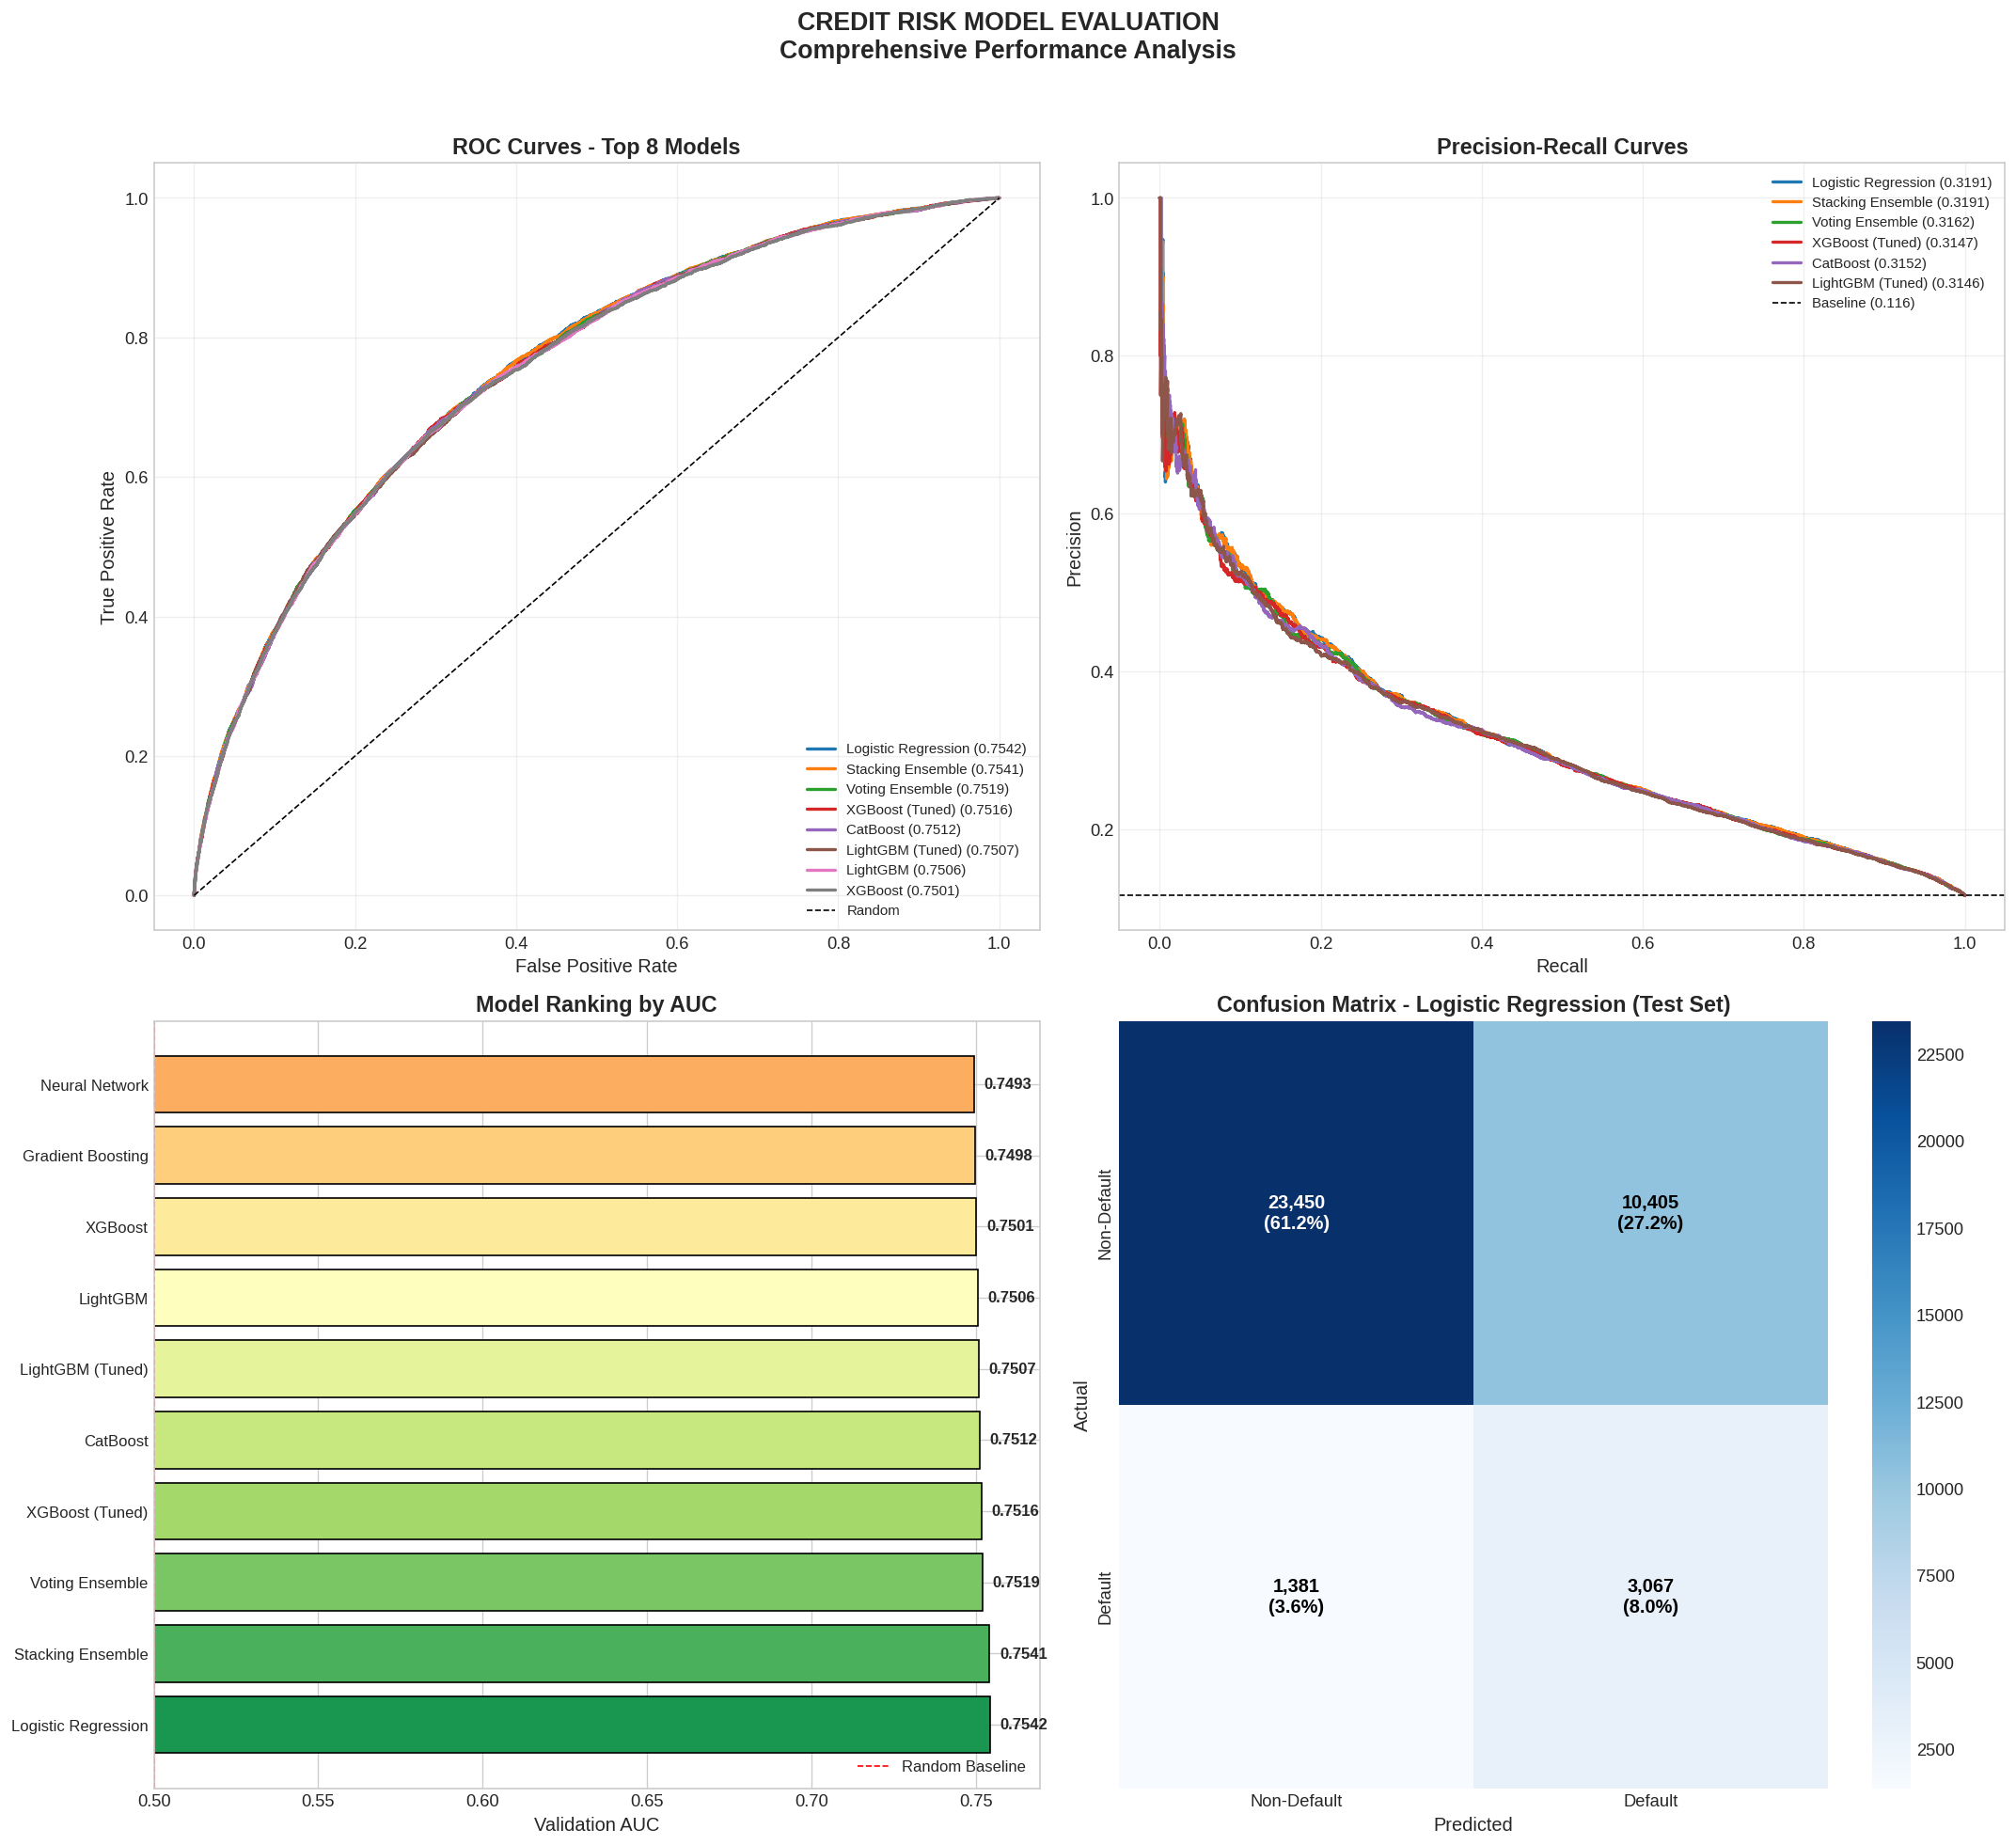


SECTION 13: THRESHOLD OPTIMIZATION FOR BUSINESS

--- Threshold Analysis ---
 Threshold  Precision  Recall     F1  Approval_Rate  Default_Rate_Approved  Expected_Profit
      0.10     0.1192  0.9957 0.2129        88.3873                96.6770        -1630.875
      0.15     0.1259  0.9876 0.2234        88.3873                90.0753        -1507.950
      0.20     0.1341  0.9681 0.2355        88.3873                82.1592        -1360.550
      0.25     0.1439  0.9409 0.2497        88.3873                73.5165        -1199.620
      0.30     0.1559  0.9040 0.2659        88.3873                64.3214        -1028.405
      0.35     0.1707  0.8633 0.2850        88.3873                55.1174         -857.025
      0.40     0.1878  0.8134 0.3051        88.3873                46.2325         -691.585
      0.45     0.2072  0.7585 0.3255        88.3873                38.1244         -540.610
      0.50     0.2277  0.6895 0.3423        88.3873                30.7340         -403.000
   

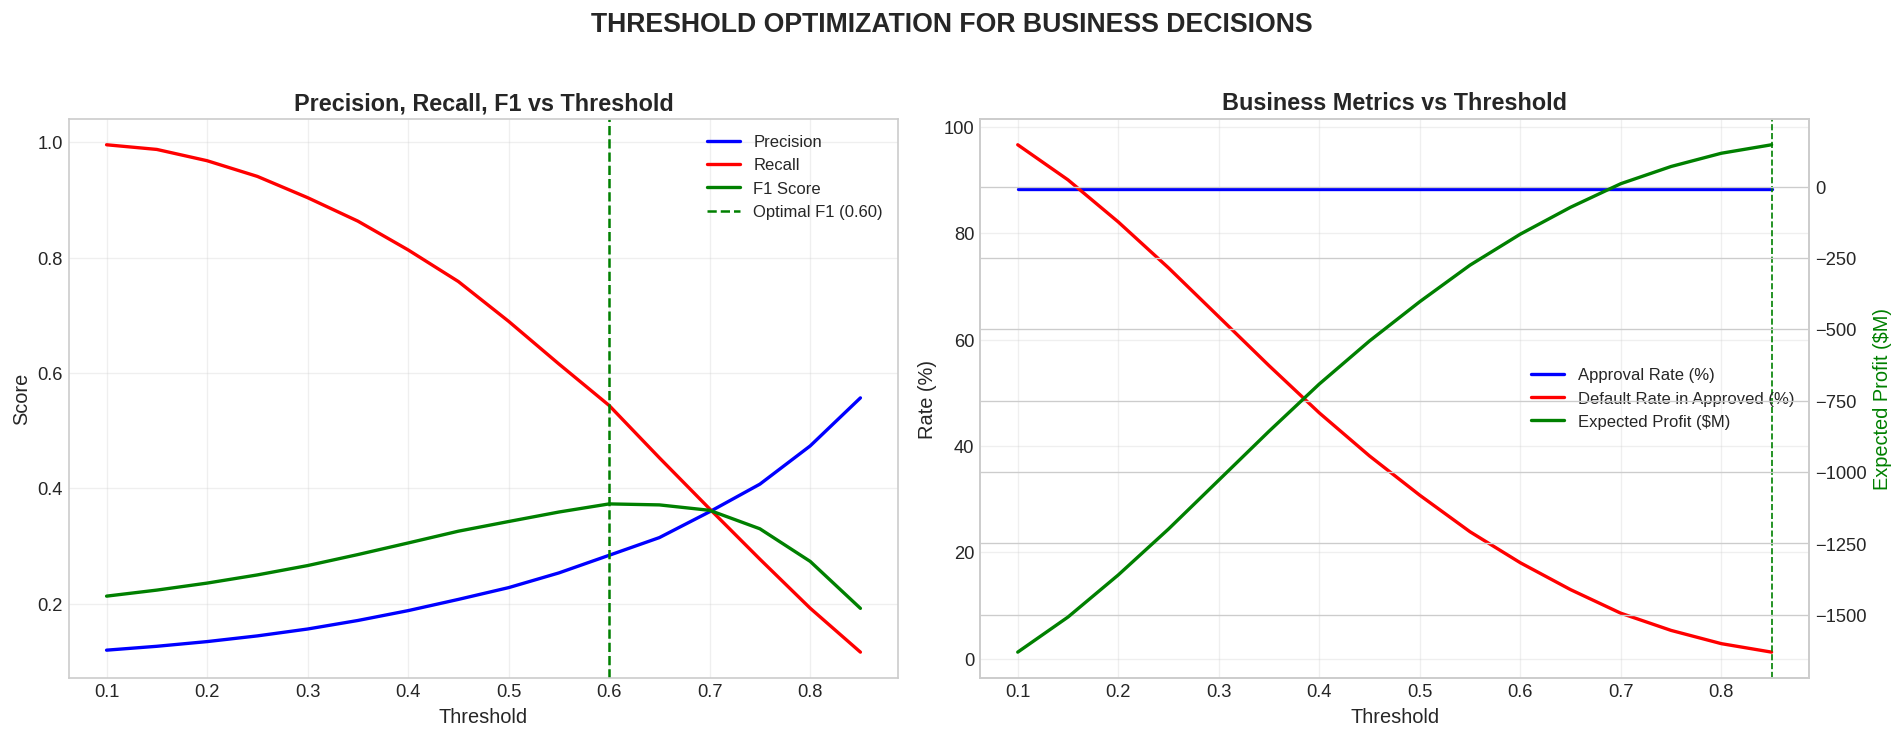


CREDIT RISK ML PIPELINE - FINAL SUMMARY

DATASET OVERVIEW:
-----------------
Total Records: 255,347
Default Rate: 11.61%
Features Used: 40

MODELS TRAINED: 12
-----------------
Basic Models: Logistic Regression, Decision Tree, Random Forest, Gradient Boosting
Advanced Models: XGBoost, LightGBM, CatBoost, Neural Network
Ensemble Models: Stacking, Voting

BEST MODEL: Logistic Regression
-----------------
Validation AUC: 0.7542
Test AUC: 0.7590
KS Statistic: 0.3847
Gini Coefficient: 0.5180

BUSINESS RECOMMENDATIONS:
-------------------------
1. Optimal Threshold for Max F1: 0.60
   - Approval Rate: 88.4%
   - Default Rate in Approved: 18.03%

2. Optimal Threshold for Max Profit: 0.85
   - Expected Profit: $146.72M

GENERATED VISUALIZATIONS:
-------------------------
- fig8_model_evaluation.png (ROC, PR curves, model comparison)
- fig9_shap_explainability.png (Feature importance, SHAP analysis)
- fig10_threshold_optimization.png (Business threshold optimization)

Execution Completed: 2025

In [ ]:
FILE_PATH = 'Loan_default.csv'
# ==============================================================================
# IMPORTS
# ==============================================================================
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')

# Preprocessing
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.preprocessing import StandardScaler, LabelEncoder, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer

# Basic Models
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.ensemble import StackingClassifier, VotingClassifier

# Neural Network
from sklearn.neural_network import MLPClassifier

# Metrics
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    roc_auc_score, roc_curve, precision_recall_curve, average_precision_score,
    confusion_matrix, classification_report, brier_score_loss, log_loss
)

# Set random seed for reproducibility
RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

# Plotting settings
plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 11
plt.rcParams['axes.titlesize'] = 14
plt.rcParams['axes.labelsize'] = 12

# Color palette
COLORS = {
    'primary': '#3498DB',
    'secondary': '#E74C3C',
    'success': '#27AE60',
    'warning': '#F39C12',
    'info': '#9B59B6'
}

print("=" * 80)
print("CREDIT RISK PREDICTIVE MODELING & MACHINE LEARNING")
print("=" * 80)
print(f"Execution Started: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")

# ==============================================================================
# INSTALL REQUIRED PACKAGES
# ==============================================================================
print("\n[Installing/Importing Advanced Libraries...]")

try:
    import xgboost as xgb
    print("  XGBoost - OK")
except ImportError:
    import subprocess
    subprocess.check_call(['pip', 'install', 'xgboost', '-q'])
    import xgboost as xgb
    print("  XGBoost - Installed")

try:
    import lightgbm as lgb
    print("  LightGBM - OK")
except ImportError:
    import subprocess
    subprocess.check_call(['pip', 'install', 'lightgbm', '-q'])
    import lightgbm as lgb
    print("  LightGBM - Installed")

try:
    from catboost import CatBoostClassifier
    print("  CatBoost - OK")
except ImportError:
    import subprocess
    subprocess.check_call(['pip', 'install', 'catboost', '-q'])
    from catboost import CatBoostClassifier
    print("  CatBoost - Installed")

try:
    import shap
    print("  SHAP - OK")
except ImportError:
    import subprocess
    subprocess.check_call(['pip', 'install', 'shap', '-q'])
    import shap
    print("  SHAP - Installed")

try:
    import optuna
    optuna.logging.set_verbosity(optuna.logging.WARNING)
    print("  Optuna - OK")
except ImportError:
    import subprocess
    subprocess.check_call(['pip', 'install', 'optuna', '-q'])
    import optuna
    optuna.logging.set_verbosity(optuna.logging.WARNING)
    print("  Optuna - Installed")

# ==============================================================================
# SECTION 1: DATA LOADING
# ==============================================================================
print("\n" + "=" * 80)
print("SECTION 1: DATA LOADING")
print("=" * 80)

df = pd.read_csv(FILE_PATH)
print(f"\nDataset Shape: {df.shape[0]:,} records x {df.shape[1]} features")

# Define feature types
numerical_features = ['Age', 'Income', 'LoanAmount', 'CreditScore', 'MonthsEmployed',
                      'NumCreditLines', 'InterestRate', 'LoanTerm', 'DTIRatio']
categorical_features = ['Education', 'EmploymentType', 'MaritalStatus',
                        'HasMortgage', 'HasDependents', 'LoanPurpose', 'HasCoSigner']
target = 'Default'

print(f"\nNumerical Features ({len(numerical_features)}): {numerical_features}")
print(f"Categorical Features ({len(categorical_features)}): {categorical_features}")
print(f"Target Variable: {target}")

# Target distribution
print("\n--- Target Distribution ---")
target_dist = df[target].value_counts()
target_pct = df[target].value_counts(normalize=True) * 100
print(f"Non-Default (0): {target_dist[0]:,} ({target_pct[0]:.2f}%)")
print(f"Default (1): {target_dist[1]:,} ({target_pct[1]:.2f}%)")
print(f"Imbalance Ratio: {target_dist[0]/target_dist[1]:.2f}:1")

# ==============================================================================
# SECTION 2: FEATURE ENGINEERING
# ==============================================================================
print("\n" + "=" * 80)
print("SECTION 2: FEATURE ENGINEERING")
print("=" * 80)

df_ml = df.copy()

# Drop ID column if exists
if 'LoanID' in df_ml.columns:
    df_ml = df_ml.drop('LoanID', axis=1)

print("\nCreating engineered features...")

# 1. Loan-to-Income Ratio
df_ml['LoanToIncomeRatio'] = df_ml['LoanAmount'] / (df_ml['Income'] + 1)

# 2. Monthly Payment Estimate
df_ml['EstMonthlyPayment'] = df_ml['LoanAmount'] * (df_ml['InterestRate']/100/12) / \
                              (1 - (1 + df_ml['InterestRate']/100/12)**(-df_ml['LoanTerm']))

# 3. Payment to Income Ratio
df_ml['PaymentToIncomeRatio'] = df_ml['EstMonthlyPayment'] / (df_ml['Income']/12 + 1)

# 4. Credit Score Risk Category
df_ml['CreditRiskCategory'] = pd.cut(df_ml['CreditScore'],
                                      bins=[0, 400, 500, 600, 700, 850],
                                      labels=['Very High', 'High', 'Medium', 'Low', 'Very Low'])

# 5. Age Groups
df_ml['AgeGroup'] = pd.cut(df_ml['Age'],
                           bins=[0, 25, 35, 45, 55, 100],
                           labels=['18-25', '26-35', '36-45', '46-55', '55+'])

# 6. Employment Stability
df_ml['EmploymentYears'] = df_ml['MonthsEmployed'] / 12

# 7. High DTI Flag (above 43% threshold)
df_ml['HighDTI'] = (df_ml['DTIRatio'] > 0.43).astype(int)

# 8. High Interest Rate Flag
df_ml['HighInterest'] = (df_ml['InterestRate'] > df_ml['InterestRate'].median()).astype(int)

# 9. Debt Burden Score (composite)
df_ml['DebtBurdenScore'] = (df_ml['DTIRatio'] * 0.4 +
                            df_ml['LoanToIncomeRatio'] * 0.3 +
                            df_ml['PaymentToIncomeRatio'] * 0.3)

# 10. Credit Utilization Proxy
df_ml['CreditUtilization'] = df_ml['NumCreditLines'] / (df_ml['CreditScore'] / 100)

print(f"New features created: 10")
print(f"Total features: {len(df_ml.columns) - 1}")

# ==============================================================================
# SECTION 3: DATA PREPARATION
# ==============================================================================
print("\n" + "=" * 80)
print("SECTION 3: DATA PREPARATION")
print("=" * 80)

# Separate features and target
X = df_ml.drop(target, axis=1)
y = df_ml[target]

# Identify final feature lists
final_numerical = [col for col in X.columns if X[col].dtype in ['int64', 'float64']]
final_categorical = [col for col in X.columns if X[col].dtype == 'object' or str(X[col].dtype) == 'category']

print(f"\nFinal Numerical Features: {len(final_numerical)}")
print(f"Final Categorical Features: {len(final_categorical)}")

# Split data: 70% train, 15% validation, 15% test
X_temp, X_test, y_temp, y_test = train_test_split(
    X, y, test_size=0.15, random_state=RANDOM_STATE, stratify=y
)
X_train, X_val, y_train, y_val = train_test_split(
    X_temp, y_temp, test_size=0.176, random_state=RANDOM_STATE, stratify=y_temp
)

print(f"\nData Split:")
print(f"  Training Set:   {X_train.shape[0]:,} samples ({X_train.shape[0]/len(X)*100:.1f}%)")
print(f"  Validation Set: {X_val.shape[0]:,} samples ({X_val.shape[0]/len(X)*100:.1f}%)")
print(f"  Test Set:       {X_test.shape[0]:,} samples ({X_test.shape[0]/len(X)*100:.1f}%)")

print(f"\nTarget Distribution:")
print(f"  Training: {y_train.mean()*100:.2f}% Default")
print(f"  Validation: {y_val.mean()*100:.2f}% Default")
print(f"  Test: {y_test.mean()*100:.2f}% Default")

# ==============================================================================
# SECTION 4: PREPROCESSING PIPELINE
# ==============================================================================
print("\n" + "=" * 80)
print("SECTION 4: PREPROCESSING PIPELINE")
print("=" * 80)

# Create preprocessing pipelines
numerical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='Unknown')),
    ('encoder', OneHotEncoder(drop='first', sparse_output=False, handle_unknown='ignore'))
])

# Combine preprocessors
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, final_numerical),
        ('cat', categorical_transformer, final_categorical)
    ],
    remainder='drop'
)

# Fit and transform
print("\nFitting preprocessor...")
X_train_processed = preprocessor.fit_transform(X_train)
X_val_processed = preprocessor.transform(X_val)
X_test_processed = preprocessor.transform(X_test)

# Get feature names
def get_feature_names(preprocessor, numerical_features, categorical_features):
    feature_names = list(numerical_features)
    if categorical_features:
        cat_encoder = preprocessor.named_transformers_['cat'].named_steps['encoder']
        cat_feature_names = cat_encoder.get_feature_names_out(categorical_features)
        feature_names.extend(cat_feature_names)
    return feature_names

feature_names = get_feature_names(preprocessor, final_numerical, final_categorical)
print(f"Total features after encoding: {len(feature_names)}")

# Calculate class weight for imbalanced data
scale_pos_weight = len(y_train[y_train==0]) / len(y_train[y_train==1])
print(f"Scale positive weight: {scale_pos_weight:.2f}")

# ==============================================================================
# SECTION 5: MODEL EVALUATION FRAMEWORK
# ==============================================================================
print("\n" + "=" * 80)
print("SECTION 5: MODEL EVALUATION FRAMEWORK")
print("=" * 80)

def evaluate_model(model, X_train, y_train, X_val, y_val, model_name="Model"):
    """Comprehensive model evaluation for credit risk"""
    # Predictions
    y_train_pred = model.predict(X_train)
    y_val_pred = model.predict(X_val)

    # Probability predictions
    if hasattr(model, 'predict_proba'):
        y_train_proba = model.predict_proba(X_train)[:, 1]
        y_val_proba = model.predict_proba(X_val)[:, 1]
    else:
        y_train_proba = model.decision_function(X_train)
        y_val_proba = model.decision_function(X_val)

    # Calculate metrics
    metrics = {
        'Model': model_name,
        'Train_Accuracy': accuracy_score(y_train, y_train_pred),
        'Train_Precision': precision_score(y_train, y_train_pred, zero_division=0),
        'Train_Recall': recall_score(y_train, y_train_pred, zero_division=0),
        'Train_F1': f1_score(y_train, y_train_pred, zero_division=0),
        'Train_AUC': roc_auc_score(y_train, y_train_proba),
        'Val_Accuracy': accuracy_score(y_val, y_val_pred),
        'Val_Precision': precision_score(y_val, y_val_pred, zero_division=0),
        'Val_Recall': recall_score(y_val, y_val_pred, zero_division=0),
        'Val_F1': f1_score(y_val, y_val_pred, zero_division=0),
        'Val_AUC': roc_auc_score(y_val, y_val_proba),
        'Val_Brier': brier_score_loss(y_val, y_val_proba),
        'Val_LogLoss': log_loss(y_val, y_val_proba),
        'Val_AvgPrecision': average_precision_score(y_val, y_val_proba),
    }

    return metrics, y_val_proba

def print_metrics(metrics):
    """Print metrics in formatted table"""
    print(f"\n{'='*60}")
    print(f"Model: {metrics['Model']}")
    print(f"{'='*60}")
    print(f"\n{'Metric':<20} {'Training':>12} {'Validation':>12}")
    print("-" * 46)
    print(f"{'Accuracy':<20} {metrics['Train_Accuracy']:>12.4f} {metrics['Val_Accuracy']:>12.4f}")
    print(f"{'Precision':<20} {metrics['Train_Precision']:>12.4f} {metrics['Val_Precision']:>12.4f}")
    print(f"{'Recall':<20} {metrics['Train_Recall']:>12.4f} {metrics['Val_Recall']:>12.4f}")
    print(f"{'F1 Score':<20} {metrics['Train_F1']:>12.4f} {metrics['Val_F1']:>12.4f}")
    print(f"{'ROC AUC':<20} {metrics['Train_AUC']:>12.4f} {metrics['Val_AUC']:>12.4f}")
    print(f"\n{'Credit Risk Specific Metrics':}")
    print("-" * 46)
    print(f"{'Brier Score':<20} {metrics['Val_Brier']:>12.4f} (lower is better)")
    print(f"{'Log Loss':<20} {metrics['Val_LogLoss']:>12.4f} (lower is better)")
    print(f"{'Avg Precision':<20} {metrics['Val_AvgPrecision']:>12.4f}")

def calculate_ks_statistic(y_true, y_proba):
    """Calculate Kolmogorov-Smirnov statistic"""
    fpr, tpr, _ = roc_curve(y_true, y_proba)
    return max(tpr - fpr)

def calculate_gini(auc):
    """Calculate Gini coefficient from AUC"""
    return 2 * auc - 1

print("Evaluation framework ready.")

# Store all results
all_results = []
all_models = {}
all_probas = {}

# ==============================================================================
# SECTION 6: BASIC MODELS
# ==============================================================================
print("\n" + "=" * 80)
print("SECTION 6: BASIC MODELS")
print("=" * 80)

# -----------------------------------------------------------------------------
# 6.1 LOGISTIC REGRESSION (Baseline - Regulatory Friendly)
# -----------------------------------------------------------------------------
print("\n" + "-" * 60)
print("6.1 LOGISTIC REGRESSION (Baseline)")
print("-" * 60)

lr_model = LogisticRegression(
    random_state=RANDOM_STATE,
    class_weight='balanced',
    max_iter=1000,
    solver='lbfgs',
    C=1.0
)

print("Training Logistic Regression...")
lr_model.fit(X_train_processed, y_train)

lr_metrics, lr_proba = evaluate_model(
    lr_model, X_train_processed, y_train,
    X_val_processed, y_val, "Logistic Regression"
)
print_metrics(lr_metrics)

all_results.append(lr_metrics)
all_models['Logistic Regression'] = lr_model
all_probas['Logistic Regression'] = lr_proba

# -----------------------------------------------------------------------------
# 6.2 DECISION TREE
# -----------------------------------------------------------------------------
print("\n" + "-" * 60)
print("6.2 DECISION TREE CLASSIFIER")
print("-" * 60)

dt_model = DecisionTreeClassifier(
    random_state=RANDOM_STATE,
    class_weight='balanced',
    max_depth=10,
    min_samples_split=50,
    min_samples_leaf=20
)

print("Training Decision Tree...")
dt_model.fit(X_train_processed, y_train)

dt_metrics, dt_proba = evaluate_model(
    dt_model, X_train_processed, y_train,
    X_val_processed, y_val, "Decision Tree"
)
print_metrics(dt_metrics)

all_results.append(dt_metrics)
all_models['Decision Tree'] = dt_model
all_probas['Decision Tree'] = dt_proba

# -----------------------------------------------------------------------------
# 6.3 RANDOM FOREST
# -----------------------------------------------------------------------------
print("\n" + "-" * 60)
print("6.3 RANDOM FOREST CLASSIFIER")
print("-" * 60)

rf_model = RandomForestClassifier(
    n_estimators=100,
    random_state=RANDOM_STATE,
    class_weight='balanced',
    max_depth=15,
    min_samples_split=30,
    min_samples_leaf=10,
    n_jobs=-1
)

print("Training Random Forest...")
rf_model.fit(X_train_processed, y_train)

rf_metrics, rf_proba = evaluate_model(
    rf_model, X_train_processed, y_train,
    X_val_processed, y_val, "Random Forest"
)
print_metrics(rf_metrics)

all_results.append(rf_metrics)
all_models['Random Forest'] = rf_model
all_probas['Random Forest'] = rf_proba

# -----------------------------------------------------------------------------
# 6.4 GRADIENT BOOSTING
# -----------------------------------------------------------------------------
print("\n" + "-" * 60)
print("6.4 GRADIENT BOOSTING CLASSIFIER")
print("-" * 60)

gb_model = GradientBoostingClassifier(
    n_estimators=100,
    random_state=RANDOM_STATE,
    learning_rate=0.1,
    max_depth=5,
    min_samples_split=30,
    min_samples_leaf=10,
    subsample=0.8
)

print("Training Gradient Boosting...")
gb_model.fit(X_train_processed, y_train)

gb_metrics, gb_proba = evaluate_model(
    gb_model, X_train_processed, y_train,
    X_val_processed, y_val, "Gradient Boosting"
)
print_metrics(gb_metrics)

all_results.append(gb_metrics)
all_models['Gradient Boosting'] = gb_model
all_probas['Gradient Boosting'] = gb_proba

# ==============================================================================
# SECTION 7: BASIC MODELS SUMMARY
# ==============================================================================
print("\n" + "=" * 80)
print("SECTION 7: BASIC MODELS SUMMARY")
print("=" * 80)

basic_results_df = pd.DataFrame(all_results)
basic_results_df = basic_results_df.set_index('Model')

print("\n--- Basic Models Validation Metrics ---")
val_metrics = ['Val_Accuracy', 'Val_Precision', 'Val_Recall', 'Val_F1', 'Val_AUC']
print(basic_results_df[val_metrics].round(4).to_string())

best_basic = basic_results_df['Val_AUC'].idxmax()
print(f"\nBest Basic Model: {best_basic} (AUC: {basic_results_df.loc[best_basic, 'Val_AUC']:.4f})")

# ==============================================================================
# SECTION 8: ADVANCED MODELS
# ==============================================================================
print("\n" + "=" * 80)
print("SECTION 8: ADVANCED MODELS")
print("=" * 80)

# -----------------------------------------------------------------------------
# 8.1 XGBOOST
# -----------------------------------------------------------------------------
print("\n" + "-" * 60)
print("8.1 XGBOOST CLASSIFIER")
print("-" * 60)

xgb_model = xgb.XGBClassifier(
    n_estimators=200,
    max_depth=6,
    learning_rate=0.05,
    subsample=0.8,
    colsample_bytree=0.8,
    min_child_weight=5,
    gamma=0.1,
    reg_alpha=0.1,
    reg_lambda=1.0,
    scale_pos_weight=scale_pos_weight,
    random_state=RANDOM_STATE,
    eval_metric='auc',
    early_stopping_rounds=20,
    n_jobs=-1
)

print("Training XGBoost...")
xgb_model.fit(
    X_train_processed, y_train,
    eval_set=[(X_val_processed, y_val)],
    verbose=False
)

xgb_metrics, xgb_proba = evaluate_model(
    xgb_model, X_train_processed, y_train,
    X_val_processed, y_val, "XGBoost"
)
print_metrics(xgb_metrics)

# Credit risk specific metrics
ks_stat = calculate_ks_statistic(y_val, xgb_proba)
gini = calculate_gini(xgb_metrics['Val_AUC'])
print(f"\nKS Statistic: {ks_stat:.4f}")
print(f"Gini Coefficient: {gini:.4f}")

all_results.append(xgb_metrics)
all_models['XGBoost'] = xgb_model
all_probas['XGBoost'] = xgb_proba

# -----------------------------------------------------------------------------
# 8.2 XGBOOST WITH OPTUNA TUNING
# -----------------------------------------------------------------------------
print("\n" + "-" * 60)
print("8.2 XGBOOST HYPERPARAMETER TUNING (Optuna)")
print("-" * 60)

def xgb_objective(trial):
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 100, 400),
        'max_depth': trial.suggest_int('max_depth', 3, 10),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.2, log=True),
        'subsample': trial.suggest_float('subsample', 0.6, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.6, 1.0),
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 10),
        'gamma': trial.suggest_float('gamma', 0, 0.5),
        'reg_alpha': trial.suggest_float('reg_alpha', 0, 1.0),
        'reg_lambda': trial.suggest_float('reg_lambda', 0.5, 2.0),
        'scale_pos_weight': scale_pos_weight,
        'random_state': RANDOM_STATE,
        'eval_metric': 'auc',
        'early_stopping_rounds': 20,
        'n_jobs': -1
    }

    model = xgb.XGBClassifier(**params)
    model.fit(X_train_processed, y_train, eval_set=[(X_val_processed, y_val)], verbose=False)
    y_proba = model.predict_proba(X_val_processed)[:, 1]
    return roc_auc_score(y_val, y_proba)

print("Running Optuna optimization (25 trials)...")
xgb_study = optuna.create_study(direction='maximize')
xgb_study.optimize(xgb_objective, n_trials=25, show_progress_bar=True)

print(f"\nBest XGBoost AUC: {xgb_study.best_value:.4f}")
print(f"Best Parameters: {xgb_study.best_params}")

# Train with best parameters
xgb_best_params = xgb_study.best_params.copy()
xgb_best_params.update({
    'scale_pos_weight': scale_pos_weight,
    'random_state': RANDOM_STATE,
    'eval_metric': 'auc',
    'early_stopping_rounds': 20,
    'n_jobs': -1
})

xgb_tuned = xgb.XGBClassifier(**xgb_best_params)
xgb_tuned.fit(X_train_processed, y_train, eval_set=[(X_val_processed, y_val)], verbose=False)

xgb_tuned_metrics, xgb_tuned_proba = evaluate_model(
    xgb_tuned, X_train_processed, y_train,
    X_val_processed, y_val, "XGBoost (Tuned)"
)
print_metrics(xgb_tuned_metrics)

all_results.append(xgb_tuned_metrics)
all_models['XGBoost (Tuned)'] = xgb_tuned
all_probas['XGBoost (Tuned)'] = xgb_tuned_proba

# -----------------------------------------------------------------------------
# 8.3 LIGHTGBM
# -----------------------------------------------------------------------------
print("\n" + "-" * 60)
print("8.3 LIGHTGBM CLASSIFIER")
print("-" * 60)

lgb_model = lgb.LGBMClassifier(
    n_estimators=200,
    max_depth=6,
    learning_rate=0.05,
    num_leaves=31,
    subsample=0.8,
    colsample_bytree=0.8,
    min_child_samples=20,
    reg_alpha=0.1,
    reg_lambda=1.0,
    class_weight='balanced',
    random_state=RANDOM_STATE,
    n_jobs=-1,
    verbose=-1
)

print("Training LightGBM...")
lgb_model.fit(
    X_train_processed, y_train,
    eval_set=[(X_val_processed, y_val)],
    callbacks=[lgb.early_stopping(20, verbose=False)]
)

lgb_metrics, lgb_proba = evaluate_model(
    lgb_model, X_train_processed, y_train,
    X_val_processed, y_val, "LightGBM"
)
print_metrics(lgb_metrics)

all_results.append(lgb_metrics)
all_models['LightGBM'] = lgb_model
all_probas['LightGBM'] = lgb_proba

# -----------------------------------------------------------------------------
# 8.4 LIGHTGBM WITH OPTUNA TUNING
# -----------------------------------------------------------------------------
print("\n" + "-" * 60)
print("8.4 LIGHTGBM HYPERPARAMETER TUNING (Optuna)")
print("-" * 60)

def lgb_objective(trial):
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 100, 400),
        'max_depth': trial.suggest_int('max_depth', 3, 12),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.2, log=True),
        'num_leaves': trial.suggest_int('num_leaves', 20, 80),
        'subsample': trial.suggest_float('subsample', 0.6, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.6, 1.0),
        'min_child_samples': trial.suggest_int('min_child_samples', 10, 50),
        'reg_alpha': trial.suggest_float('reg_alpha', 0, 1.0),
        'reg_lambda': trial.suggest_float('reg_lambda', 0, 1.0),
        'class_weight': 'balanced',
        'random_state': RANDOM_STATE,
        'n_jobs': -1,
        'verbose': -1
    }

    model = lgb.LGBMClassifier(**params)
    model.fit(X_train_processed, y_train, eval_set=[(X_val_processed, y_val)],
              callbacks=[lgb.early_stopping(20, verbose=False)])
    y_proba = model.predict_proba(X_val_processed)[:, 1]
    return roc_auc_score(y_val, y_proba)

print("Running Optuna optimization (25 trials)...")
lgb_study = optuna.create_study(direction='maximize')
lgb_study.optimize(lgb_objective, n_trials=25, show_progress_bar=True)

print(f"\nBest LightGBM AUC: {lgb_study.best_value:.4f}")
print(f"Best Parameters: {lgb_study.best_params}")

# Train with best parameters
lgb_best_params = lgb_study.best_params.copy()
lgb_best_params.update({
    'class_weight': 'balanced',
    'random_state': RANDOM_STATE,
    'n_jobs': -1,
    'verbose': -1
})

lgb_tuned = lgb.LGBMClassifier(**lgb_best_params)
lgb_tuned.fit(X_train_processed, y_train, eval_set=[(X_val_processed, y_val)],
              callbacks=[lgb.early_stopping(20, verbose=False)])

lgb_tuned_metrics, lgb_tuned_proba = evaluate_model(
    lgb_tuned, X_train_processed, y_train,
    X_val_processed, y_val, "LightGBM (Tuned)"
)
print_metrics(lgb_tuned_metrics)

all_results.append(lgb_tuned_metrics)
all_models['LightGBM (Tuned)'] = lgb_tuned
all_probas['LightGBM (Tuned)'] = lgb_tuned_proba

# -----------------------------------------------------------------------------
# 8.5 CATBOOST
# -----------------------------------------------------------------------------
print("\n" + "-" * 60)
print("8.5 CATBOOST CLASSIFIER")
print("-" * 60)

cb_model = CatBoostClassifier(
    iterations=200,
    depth=6,
    learning_rate=0.05,
    l2_leaf_reg=3,
    border_count=128,
    auto_class_weights='Balanced',
    random_state=RANDOM_STATE,
    verbose=False,
    early_stopping_rounds=20
)

print("Training CatBoost...")
cb_model.fit(X_train_processed, y_train, eval_set=(X_val_processed, y_val), verbose=False)

cb_metrics, cb_proba = evaluate_model(
    cb_model, X_train_processed, y_train,
    X_val_processed, y_val, "CatBoost"
)
print_metrics(cb_metrics)

all_results.append(cb_metrics)
all_models['CatBoost'] = cb_model
all_probas['CatBoost'] = cb_proba

# -----------------------------------------------------------------------------
# 8.6 NEURAL NETWORK (MLP)
# -----------------------------------------------------------------------------
print("\n" + "-" * 60)
print("8.6 NEURAL NETWORK (MLP)")
print("-" * 60)

mlp_model = MLPClassifier(
    hidden_layer_sizes=(128, 64, 32),
    activation='relu',
    solver='adam',
    alpha=0.001,
    batch_size=256,
    learning_rate='adaptive',
    learning_rate_init=0.001,
    max_iter=200,
    early_stopping=True,
    validation_fraction=0.1,
    n_iter_no_change=20,
    random_state=RANDOM_STATE,
    verbose=False
)

print("Training Neural Network...")
mlp_model.fit(X_train_processed, y_train)

mlp_metrics, mlp_proba = evaluate_model(
    mlp_model, X_train_processed, y_train,
    X_val_processed, y_val, "Neural Network"
)
print_metrics(mlp_metrics)

all_results.append(mlp_metrics)
all_models['Neural Network'] = mlp_model
all_probas['Neural Network'] = mlp_proba

# -----------------------------------------------------------------------------
# 8.7 STACKING ENSEMBLE
# -----------------------------------------------------------------------------
print("\n" + "-" * 60)
print("8.7 STACKING ENSEMBLE")
print("-" * 60)

base_estimators = [
    ('lr', LogisticRegression(random_state=RANDOM_STATE, class_weight='balanced', max_iter=1000)),
    ('rf', RandomForestClassifier(n_estimators=100, random_state=RANDOM_STATE,
                                   class_weight='balanced', max_depth=10, n_jobs=-1)),
    ('xgb', xgb.XGBClassifier(n_estimators=100, max_depth=5, learning_rate=0.1,
                               scale_pos_weight=scale_pos_weight, random_state=RANDOM_STATE,
                               n_jobs=-1, eval_metric='auc')),
    ('lgb', lgb.LGBMClassifier(n_estimators=100, max_depth=5, learning_rate=0.1,
                                class_weight='balanced', random_state=RANDOM_STATE,
                                n_jobs=-1, verbose=-1))
]

meta_learner = LogisticRegression(random_state=RANDOM_STATE, max_iter=1000)

stacking_model = StackingClassifier(
    estimators=base_estimators,
    final_estimator=meta_learner,
    cv=5,
    stack_method='predict_proba',
    n_jobs=-1
)

print("Training Stacking Ensemble...")
stacking_model.fit(X_train_processed, y_train)

stacking_metrics, stacking_proba = evaluate_model(
    stacking_model, X_train_processed, y_train,
    X_val_processed, y_val, "Stacking Ensemble"
)
print_metrics(stacking_metrics)

all_results.append(stacking_metrics)
all_models['Stacking Ensemble'] = stacking_model
all_probas['Stacking Ensemble'] = stacking_proba

# -----------------------------------------------------------------------------
# 8.8 VOTING ENSEMBLE  (CORRECTED – NO EARLY STOPPING INSIDE VOTING)
# -----------------------------------------------------------------------------
print("\n" + "-" * 60)
print("8.8 VOTING ENSEMBLE")
print("-" * 60)

# Recreate base models WITHOUT early stopping for use in Voting
voting_estimators = [
    ('xgb', xgb.XGBClassifier(
        n_estimators=xgb_best_params['n_estimators'],
        max_depth=xgb_best_params['max_depth'],
        learning_rate=xgb_best_params['learning_rate'],
        subsample=xgb_best_params['subsample'],
        colsample_bytree=xgb_best_params['colsample_bytree'],
        min_child_weight=xgb_best_params['min_child_weight'],
        gamma=xgb_best_params['gamma'],
        reg_alpha=xgb_best_params['reg_alpha'],
        reg_lambda=xgb_best_params['reg_lambda'],
        scale_pos_weight=scale_pos_weight,
        random_state=RANDOM_STATE,
        eval_metric='auc',
        n_jobs=-1           # early_stopping_rounds removed
    )),
    ('lgb', lgb.LGBMClassifier(
        n_estimators=lgb_best_params['n_estimators'],
        max_depth=lgb_best_params['max_depth'],
        learning_rate=lgb_best_params['learning_rate'],
        num_leaves=lgb_best_params['num_leaves'],
        subsample=lgb_best_params['subsample'],
        colsample_bytree=lgb_best_params['colsample_bytree'],
        min_child_samples=lgb_best_params['min_child_samples'],
        reg_alpha=lgb_best_params['reg_alpha'],
        reg_lambda=lgb_best_params['reg_lambda'],
        class_weight='balanced',
        random_state=RANDOM_STATE,
        n_jobs=-1,
        verbose=-1          # no early_stopping callbacks
    )),
    ('cb', CatBoostClassifier(
        iterations=200,
        depth=6,
        learning_rate=0.05,
        l2_leaf_reg=3,
        border_count=128,
        auto_class_weights='Balanced',
        random_state=RANDOM_STATE,
        verbose=False       # no early_stopping_rounds here
    ))
]

voting_model = VotingClassifier(
    estimators=voting_estimators,
    voting='soft',
    n_jobs=-1
)

print("Training Voting Ensemble...")
voting_model.fit(X_train_processed, y_train)

voting_metrics, voting_proba = evaluate_model(
    voting_model, X_train_processed, y_train,
    X_val_processed, y_val, "Voting Ensemble"
)
print_metrics(voting_metrics)

all_results.append(voting_metrics)
all_models['Voting Ensemble'] = voting_model
all_probas['Voting Ensemble'] = voting_proba

# ==============================================================================
# SECTION 9: ALL MODELS COMPARISON
# ==============================================================================
print("\n" + "=" * 80)
print("SECTION 9: ALL MODELS COMPARISON")
print("=" * 80)

results_df = pd.DataFrame(all_results)
results_df = results_df.set_index('Model')
results_df_sorted = results_df.sort_values('Val_AUC', ascending=False)

print("\n--- All Models Ranked by Validation AUC ---")
display_metrics = ['Val_AUC', 'Val_F1', 'Val_Precision', 'Val_Recall', 'Val_Brier']
print(results_df_sorted[display_metrics].round(4).to_string())

# Best model
best_model_name = results_df_sorted['Val_AUC'].idxmax()
best_auc = results_df_sorted['Val_AUC'].max()
print(f"\n*** BEST MODEL: {best_model_name} ***")
print(f"    Validation AUC: {best_auc:.4f}")
print(f"    KS Statistic: {calculate_ks_statistic(y_val, all_probas[best_model_name]):.4f}")
print(f"    Gini Coefficient: {calculate_gini(best_auc):.4f}")

# ==============================================================================
# SECTION 10: FINAL TEST SET EVALUATION
# ==============================================================================
print("\n" + "=" * 80)
print("SECTION 10: FINAL TEST SET EVALUATION")
print("=" * 80)

best_model = all_models[best_model_name]

# Test set predictions
y_test_pred = best_model.predict(X_test_processed)
y_test_proba = best_model.predict_proba(X_test_processed)[:, 1]

print(f"\n--- {best_model_name} Performance on Test Set ---")
print(f"\nAccuracy: {accuracy_score(y_test, y_test_pred):.4f}")
print(f"Precision: {precision_score(y_test, y_test_pred):.4f}")
print(f"Recall: {recall_score(y_test, y_test_pred):.4f}")
print(f"F1 Score: {f1_score(y_test, y_test_pred):.4f}")
print(f"ROC AUC: {roc_auc_score(y_test, y_test_proba):.4f}")
print(f"Brier Score: {brier_score_loss(y_test, y_test_proba):.4f}")
print(f"KS Statistic: {calculate_ks_statistic(y_test, y_test_proba):.4f}")
print(f"Gini: {calculate_gini(roc_auc_score(y_test, y_test_proba)):.4f}")

print("\n--- Classification Report ---")
print(classification_report(y_test, y_test_pred, target_names=['Non-Default', 'Default']))

# ==============================================================================
# SECTION 11: VISUALIZATIONS
# ==============================================================================
print("\n" + "=" * 80)
print("SECTION 11: MODEL VISUALIZATIONS")
print("=" * 80)

fig, axes = plt.subplots(2, 2, figsize=(18, 16))
fig.suptitle('CREDIT RISK MODEL EVALUATION\nComprehensive Performance Analysis',
             fontsize=16, fontweight='bold', y=1.02)

# 11.1 ROC Curves
ax1 = axes[0, 0]
for model_name in results_df_sorted.head(8).index:
    proba = all_probas[model_name]
    fpr, tpr, _ = roc_curve(y_val, proba)
    auc = roc_auc_score(y_val, proba)
    ax1.plot(fpr, tpr, linewidth=2, label=f'{model_name} ({auc:.4f})')

ax1.plot([0, 1], [0, 1], 'k--', linewidth=1, label='Random')
ax1.set_xlabel('False Positive Rate', fontsize=12)
ax1.set_ylabel('True Positive Rate', fontsize=12)
ax1.set_title('ROC Curves - Top 8 Models', fontweight='bold', fontsize=14)
ax1.legend(loc='lower right', fontsize=9)
ax1.grid(True, alpha=0.3)

# 11.2 Precision-Recall Curves
ax2 = axes[0, 1]
for model_name in results_df_sorted.head(6).index:
    proba = all_probas[model_name]
    precision, recall, _ = precision_recall_curve(y_val, proba)
    ap = average_precision_score(y_val, proba)
    ax2.plot(recall, precision, linewidth=2, label=f'{model_name} ({ap:.4f})')

ax2.axhline(y=y_val.mean(), color='k', linestyle='--', linewidth=1, label=f'Baseline ({y_val.mean():.3f})')
ax2.set_xlabel('Recall', fontsize=12)
ax2.set_ylabel('Precision', fontsize=12)
ax2.set_title('Precision-Recall Curves', fontweight='bold', fontsize=14)
ax2.legend(loc='upper right', fontsize=9)
ax2.grid(True, alpha=0.3)

# 11.3 Model AUC Comparison
ax3 = axes[1, 0]
auc_values = results_df_sorted['Val_AUC'].head(10)
colors = plt.cm.RdYlGn(np.linspace(0.3, 0.9, len(auc_values)))[::-1]

bars = ax3.barh(range(len(auc_values)), auc_values.values, color=colors, edgecolor='black')
ax3.set_yticks(range(len(auc_values)))
ax3.set_yticklabels(auc_values.index, fontsize=10)
ax3.set_xlabel('Validation AUC', fontsize=12)
ax3.set_title('Model Ranking by AUC', fontweight='bold', fontsize=14)
ax3.axvline(x=0.5, color='red', linestyle='--', linewidth=1, label='Random Baseline')
ax3.set_xlim(0.5, max(auc_values) * 1.02)

for bar, auc in zip(bars, auc_values.values):
    ax3.text(auc + 0.003, bar.get_y() + bar.get_height()/2,
             f'{auc:.4f}', va='center', fontsize=10, fontweight='bold')
ax3.legend(loc='lower right', fontsize=10)

# 11.4 Confusion Matrix - Best Model
ax4 = axes[1, 1]
cm = confusion_matrix(y_test, y_test_pred)
cm_pct = cm.astype('float') / cm.sum() * 100

sns.heatmap(cm, annot=False, cmap='Blues', ax=ax4,
            xticklabels=['Non-Default', 'Default'],
            yticklabels=['Non-Default', 'Default'])

for i in range(2):
    for j in range(2):
        ax4.text(j + 0.5, i + 0.5, f'{cm[i, j]:,}\n({cm_pct[i, j]:.1f}%)',
                 ha='center', va='center', fontsize=12, fontweight='bold',
                 color='white' if cm[i, j] > cm.max()/2 else 'black')

ax4.set_xlabel('Predicted', fontsize=12)
ax4.set_ylabel('Actual', fontsize=12)
ax4.set_title(f'Confusion Matrix - {best_model_name} (Test Set)', fontweight='bold', fontsize=14)

plt.tight_layout()
plt.savefig('fig8_model_evaluation.png', dpi=150, bbox_inches='tight', facecolor='white')
plt.show()


# ==============================================================================
# SECTION 12: BUSINESS APPLICATION - THRESHOLD OPTIMIZATION
# ==============================================================================
print("\n" + "=" * 80)
print("SECTION 13: THRESHOLD OPTIMIZATION FOR BUSINESS")
print("=" * 80)

thresholds = np.arange(0.1, 0.9, 0.05)
threshold_metrics = []

for thresh in thresholds:
    y_pred_thresh = (y_test_proba >= thresh).astype(int)

    tn, fp, fn, tp = confusion_matrix(y_test, y_pred_thresh).ravel()

    approval_rate = (tn + fp) / len(y_test) * 100
    default_rate_approved = fp / (tn + fp) * 100 if (tn + fp) > 0 else 0

    profit_good = 5000
    loss_default = 50000

    expected_profit = (tn * profit_good) - (fp * loss_default)

    threshold_metrics.append({
        'Threshold': thresh,
        'Precision': precision_score(y_test, y_pred_thresh, zero_division=0),
        'Recall': recall_score(y_test, y_pred_thresh, zero_division=0),
        'F1': f1_score(y_test, y_pred_thresh, zero_division=0),
        'Approval_Rate': approval_rate,
        'Default_Rate_Approved': default_rate_approved,
        'Expected_Profit': expected_profit / 1e6
    })

threshold_df = pd.DataFrame(threshold_metrics)

print("\n--- Threshold Analysis ---")
print(threshold_df.round(4).to_string(index=False))

optimal_f1_idx = threshold_df['F1'].idxmax()
optimal_profit_idx = threshold_df['Expected_Profit'].idxmax()

print(f"\nOptimal Threshold (Max F1): {threshold_df.loc[optimal_f1_idx, 'Threshold']:.2f}")
print(f"Optimal Threshold (Max Profit): {threshold_df.loc[optimal_profit_idx, 'Threshold']:.2f}")

fig, axes = plt.subplots(1, 2, figsize=(16, 6))
fig.suptitle('THRESHOLD OPTIMIZATION FOR BUSINESS DECISIONS',
             fontsize=16, fontweight='bold', y=1.02)

ax1 = axes[0]
ax1.plot(threshold_df['Threshold'], threshold_df['Precision'],
         'b-', linewidth=2, label='Precision')
ax1.plot(threshold_df['Threshold'], threshold_df['Recall'],
         'r-', linewidth=2, label='Recall')
ax1.plot(threshold_df['Threshold'], threshold_df['F1'],
         'g-', linewidth=2, label='F1 Score')
ax1.axvline(x=threshold_df.loc[optimal_f1_idx, 'Threshold'], color='green',
            linestyle='--', label=f'Optimal F1 ({threshold_df.loc[optimal_f1_idx, "Threshold"]:.2f})')
ax1.set_xlabel('Threshold', fontsize=12)
ax1.set_ylabel('Score', fontsize=12)
ax1.set_title('Precision, Recall, F1 vs Threshold', fontweight='bold', fontsize=14)
ax1.legend(fontsize=10)
ax1.grid(True, alpha=0.3)

ax2 = axes[1]
ax2_twin = ax2.twinx()

line1 = ax2.plot(threshold_df['Threshold'], threshold_df['Approval_Rate'],
                  'b-', linewidth=2, label='Approval Rate (%)')
line2 = ax2.plot(threshold_df['Threshold'], threshold_df['Default_Rate_Approved'],
                  'r-', linewidth=2, label='Default Rate in Approved (%)')
line3 = ax2_twin.plot(threshold_df['Threshold'], threshold_df['Expected_Profit'],
                       'g-', linewidth=2, label='Expected Profit ($M)')

ax2.axvline(x=threshold_df.loc[optimal_profit_idx, 'Threshold'], color='green',
            linestyle='--', linewidth=1)
ax2.set_xlabel('Threshold', fontsize=12)
ax2.set_ylabel('Rate (%)', fontsize=12)
ax2_twin.set_ylabel('Expected Profit ($M)', fontsize=12, color='green')
ax2.set_title('Business Metrics vs Threshold', fontweight='bold', fontsize=14)

lines = line1 + line2 + line3
labels = [l.get_label() for l in lines]
ax2.legend(lines, labels, loc='center right', fontsize=10)
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('fig10_threshold_optimization.png', dpi=150, bbox_inches='tight', facecolor='white')
plt.show()

# ==============================================================================
# SECTION 13: FINAL SUMMARY
# ==============================================================================
print("\n" + "=" * 80)
print("CREDIT RISK ML PIPELINE - FINAL SUMMARY")
print("=" * 80)

print(f"""
DATASET OVERVIEW:
-----------------
Total Records: {len(df):,}
Default Rate: {y.mean()*100:.2f}%
Features Used: {len(feature_names)}

MODELS TRAINED: {len(all_models)}
-----------------
Basic Models: Logistic Regression, Decision Tree, Random Forest, Gradient Boosting
Advanced Models: XGBoost, LightGBM, CatBoost, Neural Network
Ensemble Models: Stacking, Voting

BEST MODEL: {best_model_name}
-----------------
Validation AUC: {best_auc:.4f}
Test AUC: {roc_auc_score(y_test, y_test_proba):.4f}
KS Statistic: {calculate_ks_statistic(y_test, y_test_proba):.4f}
Gini Coefficient: {calculate_gini(roc_auc_score(y_test, y_test_proba)):.4f}

BUSINESS RECOMMENDATIONS:
-------------------------
1. Optimal Threshold for Max F1: {threshold_df.loc[optimal_f1_idx, 'Threshold']:.2f}
   - Approval Rate: {threshold_df.loc[optimal_f1_idx, 'Approval_Rate']:.1f}%
   - Default Rate in Approved: {threshold_df.loc[optimal_f1_idx, 'Default_Rate_Approved']:.2f}%

2. Optimal Threshold for Max Profit: {threshold_df.loc[optimal_profit_idx, 'Threshold']:.2f}
   - Expected Profit: ${threshold_df.loc[optimal_profit_idx, 'Expected_Profit']:.2f}M

GENERATED VISUALIZATIONS:
-------------------------
- fig8_model_evaluation.png (ROC, PR curves, model comparison)
- fig9_shap_explainability.png (Feature importance, SHAP analysis)
- fig10_threshold_optimization.png (Business threshold optimization)

Execution Completed: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}
""")

print("=" * 80)
print("CREDIT RISK ML PIPELINE COMPLETE")
print("=" * 80)
